In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
import random
import os

FRAC_ADMIT = 0.5


In [2]:


###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['key'] = df['R'].astype(str) + "_"  + df['T'].astype(str)



In [3]:
df_train = pd.read_csv('./df_train.csv')
df_stratum_utility = df_train[['R','T','Y']].groupby(['R','T']).mean().reset_index()
df_stratum_utility['stratum_utility'] = df_stratum_utility['Y'] 
df_stratum_utility['key'] = df_stratum_utility['R'].astype(str) + "_" + df_stratum_utility['T'].astype(str)

df = df.merge(df_stratum_utility[['stratum_utility','key']], on='key')
df['ml_outcomes'] = df['stratum_utility']

In [4]:
FRAC_ADMIT = 0.5#df[['A']].sum()/len(df)


In [5]:
TOTAL_ADMITS = int(len(df)*FRAC_ADMIT)
MAX_BLACK_ADMITS = len(df[df['R']==1])
MIN_GRADUATES = 10000
GRID_SIZE = 100

outcomes_grid = []
Xs = []
Ys = []

for N_black_admits in range(0,MAX_BLACK_ADMITS):
    
    if N_black_admits % GRID_SIZE != 0:
        continue
    
    black_admits = df[df['R']==1].sort_values(by='T',ascending=False).head(n=N_black_admits)
    white_admits = df[df['R']==0].sort_values(by='T',ascending=False).head(n=TOTAL_ADMITS-N_black_admits)
    
    Y = black_admits['Y'].sum() + white_admits['Y'].sum()
    
    Xs.append(N_black_admits)
    Ys.append(Y)
    print(N_black_admits,Y)
    
    for y_iter in np.arange(MIN_GRADUATES,Y,GRID_SIZE):
        outcomes_grid.append({'min_black_admits':N_black_admits-GRID_SIZE/2, 'max_black_admits':N_black_admits+GRID_SIZE/2, 'max_graduates':y_iter+GRID_SIZE, 'min_graduates':y_iter, 'policy_exists':'Unknown'})
        

0 29349
100 29402
200 29453
300 29505
400 29551
500 29594
600 29632
700 29675
800 29715
900 29755
1000 29794
1100 29832
1200 29875
1300 29906
1400 29937
1500 29969
1600 29993
1700 30024
1800 30050
1900 30084
2000 30115
2100 30150
2200 30179
2300 30214
2400 30243
2500 30265
2600 30287
2700 30302
2800 30323
2900 30354
3000 30377
3100 30397
3200 30432
3300 30444
3400 30485
3500 30503
3600 30519
3700 30539
3800 30562
3900 30583
4000 30597
4100 30607
4200 30616
4300 30637
4400 30656
4500 30691
4600 30717
4700 30730
4800 30736
4900 30728
5000 30742
5100 30755
5200 30782
5300 30793
5400 30803
5500 30821
5600 30832
5700 30850
5800 30860
5900 30878
6000 30880
6100 30884
6200 30882
6300 30895
6400 30891
6500 30900
6600 30917
6700 30931
6800 30929
6900 30930
7000 30936
7100 30932
7200 30933
7300 30934
7400 30930
7500 30939
7600 30945
7700 30939
7800 30940
7900 30954
8000 30948
8100 30962
8200 30957
8300 30965
8400 30965
8500 30981
8600 30986
8700 30982
8800 30967
8900 30960
9000 30938
9100 30939


In [6]:
df_pareto = pd.DataFrame({'# Black Admits':Xs, '# Graduates':Ys})

dff = df[['R','T','Y']].groupby(['R','T']).count().reset_index()
dff.columns = ['R','T','N']
dff['key'] = dff['R'].astype(str) + "_" + dff['T'].astype(str)
dff2 = df[['R','T','Y']].groupby(['R','T']).mean().reset_index()
dff2.columns = ['R','T','Y']
dff2['key'] = dff['R'].astype(str) + "_" + dff['T'].astype(str)

dff = dff.merge(dff2[['key','Y']],on='key')

In [7]:
###
## Get boards passage probability in each stratum
###

df_prob = df[['R','T','Y']].groupby(['R','T']).mean().reset_index()
df_prob.columns = ['R','T','ml_outcomes_prob']
dff = dff.merge(df_prob[['ml_outcomes_prob']],left_index=True,right_index=True)


In [8]:
dff['Pr(X=X_j)'] = dff['N']/(dff['N']).sum()

In [9]:
df_decisions = None
max_utility = -1.0
solutions = 0

for C_y in np.linspace(0.0,1.0,1001):
    
    print(C_y)
    
    dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
    solver = pywraplp.Solver.CreateSolver('GLOP')

    
    applicant_stratum = []
    vars_cache = {}
    alpha_j = {}
    
    # Objective: Maximize the expected utility of the admitted students
    objective = solver.Objective()
    
    # For each stratum
    for ix, row in dff.iterrows():
        # probability of admission
        numvar = solver.NumVar(0.0, 1.0, str(ix))
        
        # store variable by index, and also by stratum R, T
        applicant_stratum.append(numvar)
        vars_cache[(row['R'],row['T'])] = numvar
        
        alpha_j[(row['R'],row['T'])] = row['alpha_j']
        
        # Benefit of admitting people is total utility in that stratum
        objective.SetCoefficient(applicant_stratum[ix], float(row['N']))
        
    objective.SetMaximization()

    # Constraint: At most K applicants
    K = int(len(df)*FRAC_ADMIT)
    admit_quota = solver.Constraint(0, K)
    
    # Total admits cannot exceed K 
    for ix, row in dff.iterrows():
        admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    

    constrain_graduate = solver.Constraint(0, 0)
    
    for ix, row in dff.iterrows():
        
        key = (row['R'],row['T'])
        n_graduate = row['Y'] * row['N']
        constrain_graduate.SetCoefficient(vars_cache[key], float(n_graduate))
    
    constrain_black_admit = solver.Constraint(0, 0)
    
    for ix, row in dff.iterrows():
        key = (row['R'],row['T'])
        n_black = row['R'] * row['N']
        constrain_black_admit.SetCoefficient(vars_cache[key], float(n_black))

    
    
    sum_alpha = 0
    R = 1 
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_minority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_minority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
    
    sum_alpha = 0
    R = 0
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_majority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_majority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
        
    count = 0 
    
    print ('Total grid cells to check: {}'.format(len(outcomes_grid)))
    
    for region in outcomes_grid:
        constrain_graduate.SetBounds(float(region['min_graduates']), float(region['max_graduates']))
        constrain_black_admit.SetBounds(float(region['min_black_admits']), float(region['max_black_admits']))
        status = solver.Solve()
        count+=1
        
        if count % 1000 ==0:
            print ('Total grid cells checked so far: {}/{}, Solutions: {}'.format(count,len(outcomes_grid),solutions))


        if status == 0:
            
            if region['policy_exists'] != 1:
                solutions+=1
            
            region['policy_exists'] = 1
            row = []
            admit = []
    
            for i in applicant_stratum:
                row.append(int(str(i)))
                admit.append(i.solution_value())
            #df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
            region['policy'] = (row,admit)    
        else:
            continue
            #print(status)
            



0.0
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions:

Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions:

Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions:

Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.009000000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Tota

Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.011
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions:

Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions:

Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions:

Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.02
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells ch

Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.022
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions:

Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions:

Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions:

Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.031
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells c

Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.033
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions:

Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions:

Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions:

Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions:

Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.044
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0


Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions:

Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions:

Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions:

Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.055
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked

Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Tot

Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions:

Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions:

Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions:

Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.066
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells chec

Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total 

Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions:

Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions:

Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions:

Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.077
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells ch

Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.079
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions:

Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions:

Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions:

Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.088
Total grid cells to check: 63300
Total grid cells 

Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.09
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so

Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions:

Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions:

Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions:

Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions:

Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.101
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0


Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions:

Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions:

Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions:

Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.112
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked 

Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
To

Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions:

Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions:

Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions:

Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.123
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checke

Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Tota

Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions:

Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions:

Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions:

Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.134
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells chec

Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total 

Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions:

Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions:

Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions:

Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.145
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells c

Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.147
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions:

Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions:

Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions:

Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions:

Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.158
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 

Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions:

Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions:

Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions:

Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.169
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
T

Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions:

Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions:

Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions:

Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.18
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked

Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Tota

Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions:

Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions:

Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions:

Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.191
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells che

Total grid cells checked so far: 63000/63300, Solutions: 0
0.193
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions:

Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions:

Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions:

Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.202
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells c

Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.20400000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid c

Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions:

Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions:

Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions:

Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions:

Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.215
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0

Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions:

Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions:

Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions:

Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.226
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 

Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions:

Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions:

Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions:

Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.23700000000000002
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid c

Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0

Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions:

Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions:

Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions:

Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.248
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked 

Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
T

Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions:

Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions:

Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions:

Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.259
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked

Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
To

Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions:

Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions:

Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions:

Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.27
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked 

Total grid cells checked so far: 5000/63300, Solutions: 6
Total grid cells checked so far: 6000/63300, Solutions: 6
Total grid cells checked so far: 7000/63300, Solutions: 6
Total grid cells checked so far: 8000/63300, Solutions: 6
Total grid cells checked so far: 9000/63300, Solutions: 6
Total grid cells checked so far: 10000/63300, Solutions: 13
Total grid cells checked so far: 11000/63300, Solutions: 15
Total grid cells checked so far: 12000/63300, Solutions: 15
Total grid cells checked so far: 13000/63300, Solutions: 15
Total grid cells checked so far: 14000/63300, Solutions: 15
Total grid cells checked so far: 15000/63300, Solutions: 15
Total grid cells checked so far: 16000/63300, Solutions: 15
Total grid cells checked so far: 17000/63300, Solutions: 15
Total grid cells checked so far: 18000/63300, Solutions: 15
Total grid cells checked so far: 19000/63300, Solutions: 15
Total grid cells checked so far: 20000/63300, Solutions: 15
Total grid cells checked so far: 21000/63300, Solu

Total grid cells checked so far: 15000/63300, Solutions: 41
Total grid cells checked so far: 16000/63300, Solutions: 41
Total grid cells checked so far: 17000/63300, Solutions: 41
Total grid cells checked so far: 18000/63300, Solutions: 41
Total grid cells checked so far: 19000/63300, Solutions: 41
Total grid cells checked so far: 20000/63300, Solutions: 41
Total grid cells checked so far: 21000/63300, Solutions: 41
Total grid cells checked so far: 22000/63300, Solutions: 41
Total grid cells checked so far: 23000/63300, Solutions: 41
Total grid cells checked so far: 24000/63300, Solutions: 41
Total grid cells checked so far: 25000/63300, Solutions: 41
Total grid cells checked so far: 26000/63300, Solutions: 41
Total grid cells checked so far: 27000/63300, Solutions: 41
Total grid cells checked so far: 28000/63300, Solutions: 41
Total grid cells checked so far: 29000/63300, Solutions: 41
Total grid cells checked so far: 30000/63300, Solutions: 41
Total grid cells checked so far: 31000/6

Total grid cells checked so far: 25000/63300, Solutions: 82
Total grid cells checked so far: 26000/63300, Solutions: 82
Total grid cells checked so far: 27000/63300, Solutions: 82
Total grid cells checked so far: 28000/63300, Solutions: 82
Total grid cells checked so far: 29000/63300, Solutions: 82
Total grid cells checked so far: 30000/63300, Solutions: 82
Total grid cells checked so far: 31000/63300, Solutions: 82
Total grid cells checked so far: 32000/63300, Solutions: 82
Total grid cells checked so far: 33000/63300, Solutions: 82
Total grid cells checked so far: 34000/63300, Solutions: 82
Total grid cells checked so far: 35000/63300, Solutions: 82
Total grid cells checked so far: 36000/63300, Solutions: 82
Total grid cells checked so far: 37000/63300, Solutions: 82
Total grid cells checked so far: 38000/63300, Solutions: 82
Total grid cells checked so far: 39000/63300, Solutions: 82
Total grid cells checked so far: 40000/63300, Solutions: 82
Total grid cells checked so far: 41000/6

Total grid cells checked so far: 35000/63300, Solutions: 137
Total grid cells checked so far: 36000/63300, Solutions: 137
Total grid cells checked so far: 37000/63300, Solutions: 137
Total grid cells checked so far: 38000/63300, Solutions: 137
Total grid cells checked so far: 39000/63300, Solutions: 137
Total grid cells checked so far: 40000/63300, Solutions: 137
Total grid cells checked so far: 41000/63300, Solutions: 137
Total grid cells checked so far: 42000/63300, Solutions: 137
Total grid cells checked so far: 43000/63300, Solutions: 137
Total grid cells checked so far: 44000/63300, Solutions: 137
Total grid cells checked so far: 45000/63300, Solutions: 137
Total grid cells checked so far: 46000/63300, Solutions: 137
Total grid cells checked so far: 47000/63300, Solutions: 137
Total grid cells checked so far: 48000/63300, Solutions: 137
Total grid cells checked so far: 49000/63300, Solutions: 137
Total grid cells checked so far: 50000/63300, Solutions: 137
Total grid cells checked

Total grid cells checked so far: 43000/63300, Solutions: 208
Total grid cells checked so far: 44000/63300, Solutions: 208
Total grid cells checked so far: 45000/63300, Solutions: 208
Total grid cells checked so far: 46000/63300, Solutions: 208
Total grid cells checked so far: 47000/63300, Solutions: 208
Total grid cells checked so far: 48000/63300, Solutions: 208
Total grid cells checked so far: 49000/63300, Solutions: 208
Total grid cells checked so far: 50000/63300, Solutions: 208
Total grid cells checked so far: 51000/63300, Solutions: 208
Total grid cells checked so far: 52000/63300, Solutions: 208
Total grid cells checked so far: 53000/63300, Solutions: 208
Total grid cells checked so far: 54000/63300, Solutions: 208
Total grid cells checked so far: 55000/63300, Solutions: 208
Total grid cells checked so far: 56000/63300, Solutions: 208
Total grid cells checked so far: 57000/63300, Solutions: 208
Total grid cells checked so far: 58000/63300, Solutions: 208
Total grid cells checked

Total grid cells checked so far: 52000/63300, Solutions: 294
Total grid cells checked so far: 53000/63300, Solutions: 294
Total grid cells checked so far: 54000/63300, Solutions: 294
Total grid cells checked so far: 55000/63300, Solutions: 294
Total grid cells checked so far: 56000/63300, Solutions: 294
Total grid cells checked so far: 57000/63300, Solutions: 294
Total grid cells checked so far: 58000/63300, Solutions: 294
Total grid cells checked so far: 59000/63300, Solutions: 294
Total grid cells checked so far: 60000/63300, Solutions: 294
Total grid cells checked so far: 61000/63300, Solutions: 294
Total grid cells checked so far: 62000/63300, Solutions: 294
Total grid cells checked so far: 63000/63300, Solutions: 294
0.28300000000000003
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 294
Total grid cells checked so far: 2000/63300, Solutions: 294
Total grid cells checked so far: 3000/63300, Solutions: 294
Total grid cells checked so far: 40

Total grid cells checked so far: 59000/63300, Solutions: 396
Total grid cells checked so far: 60000/63300, Solutions: 396
Total grid cells checked so far: 61000/63300, Solutions: 396
Total grid cells checked so far: 62000/63300, Solutions: 396
Total grid cells checked so far: 63000/63300, Solutions: 396
0.28500000000000003
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 396
Total grid cells checked so far: 2000/63300, Solutions: 396
Total grid cells checked so far: 3000/63300, Solutions: 396
Total grid cells checked so far: 4000/63300, Solutions: 396
Total grid cells checked so far: 5000/63300, Solutions: 396
Total grid cells checked so far: 6000/63300, Solutions: 396
Total grid cells checked so far: 7000/63300, Solutions: 413
Total grid cells checked so far: 8000/63300, Solutions: 417
Total grid cells checked so far: 9000/63300, Solutions: 423
Total grid cells checked so far: 10000/63300, Solutions: 429
Total grid cells checked so far: 11000/63

Total grid cells checked so far: 4000/63300, Solutions: 516
Total grid cells checked so far: 5000/63300, Solutions: 516
Total grid cells checked so far: 6000/63300, Solutions: 530
Total grid cells checked so far: 7000/63300, Solutions: 535
Total grid cells checked so far: 8000/63300, Solutions: 540
Total grid cells checked so far: 9000/63300, Solutions: 546
Total grid cells checked so far: 10000/63300, Solutions: 551
Total grid cells checked so far: 11000/63300, Solutions: 557
Total grid cells checked so far: 12000/63300, Solutions: 563
Total grid cells checked so far: 13000/63300, Solutions: 567
Total grid cells checked so far: 14000/63300, Solutions: 573
Total grid cells checked so far: 15000/63300, Solutions: 579
Total grid cells checked so far: 16000/63300, Solutions: 584
Total grid cells checked so far: 17000/63300, Solutions: 584
Total grid cells checked so far: 18000/63300, Solutions: 584
Total grid cells checked so far: 19000/63300, Solutions: 584
Total grid cells checked so fa

Total grid cells checked so far: 12000/63300, Solutions: 712
Total grid cells checked so far: 13000/63300, Solutions: 716
Total grid cells checked so far: 14000/63300, Solutions: 722
Total grid cells checked so far: 15000/63300, Solutions: 727
Total grid cells checked so far: 16000/63300, Solutions: 732
Total grid cells checked so far: 17000/63300, Solutions: 736
Total grid cells checked so far: 18000/63300, Solutions: 736
Total grid cells checked so far: 19000/63300, Solutions: 736
Total grid cells checked so far: 20000/63300, Solutions: 736
Total grid cells checked so far: 21000/63300, Solutions: 736
Total grid cells checked so far: 22000/63300, Solutions: 736
Total grid cells checked so far: 23000/63300, Solutions: 736
Total grid cells checked so far: 24000/63300, Solutions: 736
Total grid cells checked so far: 25000/63300, Solutions: 736
Total grid cells checked so far: 26000/63300, Solutions: 736
Total grid cells checked so far: 27000/63300, Solutions: 736
Total grid cells checked

Total grid cells checked so far: 20000/63300, Solutions: 907
Total grid cells checked so far: 21000/63300, Solutions: 907
Total grid cells checked so far: 22000/63300, Solutions: 907
Total grid cells checked so far: 23000/63300, Solutions: 907
Total grid cells checked so far: 24000/63300, Solutions: 907
Total grid cells checked so far: 25000/63300, Solutions: 907
Total grid cells checked so far: 26000/63300, Solutions: 907
Total grid cells checked so far: 27000/63300, Solutions: 907
Total grid cells checked so far: 28000/63300, Solutions: 907
Total grid cells checked so far: 29000/63300, Solutions: 907
Total grid cells checked so far: 30000/63300, Solutions: 907
Total grid cells checked so far: 31000/63300, Solutions: 907
Total grid cells checked so far: 32000/63300, Solutions: 907
Total grid cells checked so far: 33000/63300, Solutions: 907
Total grid cells checked so far: 34000/63300, Solutions: 907
Total grid cells checked so far: 35000/63300, Solutions: 907
Total grid cells checked

Total grid cells checked so far: 28000/63300, Solutions: 1096
Total grid cells checked so far: 29000/63300, Solutions: 1096
Total grid cells checked so far: 30000/63300, Solutions: 1096
Total grid cells checked so far: 31000/63300, Solutions: 1096
Total grid cells checked so far: 32000/63300, Solutions: 1096
Total grid cells checked so far: 33000/63300, Solutions: 1096
Total grid cells checked so far: 34000/63300, Solutions: 1096
Total grid cells checked so far: 35000/63300, Solutions: 1096
Total grid cells checked so far: 36000/63300, Solutions: 1096
Total grid cells checked so far: 37000/63300, Solutions: 1096
Total grid cells checked so far: 38000/63300, Solutions: 1096
Total grid cells checked so far: 39000/63300, Solutions: 1096
Total grid cells checked so far: 40000/63300, Solutions: 1096
Total grid cells checked so far: 41000/63300, Solutions: 1096
Total grid cells checked so far: 42000/63300, Solutions: 1096
Total grid cells checked so far: 43000/63300, Solutions: 1096
Total gr

Total grid cells checked so far: 34000/63300, Solutions: 1297
Total grid cells checked so far: 35000/63300, Solutions: 1297
Total grid cells checked so far: 36000/63300, Solutions: 1297
Total grid cells checked so far: 37000/63300, Solutions: 1297
Total grid cells checked so far: 38000/63300, Solutions: 1297
Total grid cells checked so far: 39000/63300, Solutions: 1297
Total grid cells checked so far: 40000/63300, Solutions: 1297
Total grid cells checked so far: 41000/63300, Solutions: 1297
Total grid cells checked so far: 42000/63300, Solutions: 1297
Total grid cells checked so far: 43000/63300, Solutions: 1297
Total grid cells checked so far: 44000/63300, Solutions: 1297
Total grid cells checked so far: 45000/63300, Solutions: 1297
Total grid cells checked so far: 46000/63300, Solutions: 1297
Total grid cells checked so far: 47000/63300, Solutions: 1297
Total grid cells checked so far: 48000/63300, Solutions: 1297
Total grid cells checked so far: 49000/63300, Solutions: 1297
Total gr

Total grid cells checked so far: 40000/63300, Solutions: 1494
Total grid cells checked so far: 41000/63300, Solutions: 1494
Total grid cells checked so far: 42000/63300, Solutions: 1494
Total grid cells checked so far: 43000/63300, Solutions: 1494
Total grid cells checked so far: 44000/63300, Solutions: 1494
Total grid cells checked so far: 45000/63300, Solutions: 1494
Total grid cells checked so far: 46000/63300, Solutions: 1494
Total grid cells checked so far: 47000/63300, Solutions: 1494
Total grid cells checked so far: 48000/63300, Solutions: 1494
Total grid cells checked so far: 49000/63300, Solutions: 1494
Total grid cells checked so far: 50000/63300, Solutions: 1494
Total grid cells checked so far: 51000/63300, Solutions: 1494
Total grid cells checked so far: 52000/63300, Solutions: 1494
Total grid cells checked so far: 53000/63300, Solutions: 1494
Total grid cells checked so far: 54000/63300, Solutions: 1494
Total grid cells checked so far: 55000/63300, Solutions: 1494
Total gr

Total grid cells checked so far: 46000/63300, Solutions: 1735
Total grid cells checked so far: 47000/63300, Solutions: 1735
Total grid cells checked so far: 48000/63300, Solutions: 1735
Total grid cells checked so far: 49000/63300, Solutions: 1735
Total grid cells checked so far: 50000/63300, Solutions: 1735
Total grid cells checked so far: 51000/63300, Solutions: 1735
Total grid cells checked so far: 52000/63300, Solutions: 1735
Total grid cells checked so far: 53000/63300, Solutions: 1735
Total grid cells checked so far: 54000/63300, Solutions: 1735
Total grid cells checked so far: 55000/63300, Solutions: 1735
Total grid cells checked so far: 56000/63300, Solutions: 1735
Total grid cells checked so far: 57000/63300, Solutions: 1735
Total grid cells checked so far: 58000/63300, Solutions: 1735
Total grid cells checked so far: 59000/63300, Solutions: 1735
Total grid cells checked so far: 60000/63300, Solutions: 1735
Total grid cells checked so far: 61000/63300, Solutions: 1735
Total gr

Total grid cells checked so far: 52000/63300, Solutions: 1999
Total grid cells checked so far: 53000/63300, Solutions: 1999
Total grid cells checked so far: 54000/63300, Solutions: 1999
Total grid cells checked so far: 55000/63300, Solutions: 1999
Total grid cells checked so far: 56000/63300, Solutions: 1999
Total grid cells checked so far: 57000/63300, Solutions: 1999
Total grid cells checked so far: 58000/63300, Solutions: 1999
Total grid cells checked so far: 59000/63300, Solutions: 1999
Total grid cells checked so far: 60000/63300, Solutions: 1999
Total grid cells checked so far: 61000/63300, Solutions: 1999
Total grid cells checked so far: 62000/63300, Solutions: 1999
Total grid cells checked so far: 63000/63300, Solutions: 1999
0.302
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 1999
Total grid cells checked so far: 2000/63300, Solutions: 1999
Total grid cells checked so far: 3000/63300, Solutions: 1999
Total grid cells checked so far: 4

Total grid cells checked so far: 58000/63300, Solutions: 2284
Total grid cells checked so far: 59000/63300, Solutions: 2284
Total grid cells checked so far: 60000/63300, Solutions: 2284
Total grid cells checked so far: 61000/63300, Solutions: 2284
Total grid cells checked so far: 62000/63300, Solutions: 2284
Total grid cells checked so far: 63000/63300, Solutions: 2284
0.304
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 2284
Total grid cells checked so far: 2000/63300, Solutions: 2284
Total grid cells checked so far: 3000/63300, Solutions: 2316
Total grid cells checked so far: 4000/63300, Solutions: 2323
Total grid cells checked so far: 5000/63300, Solutions: 2328
Total grid cells checked so far: 6000/63300, Solutions: 2335
Total grid cells checked so far: 7000/63300, Solutions: 2340
Total grid cells checked so far: 8000/63300, Solutions: 2344
Total grid cells checked so far: 9000/63300, Solutions: 2351
Total grid cells checked so far: 10000/6

Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 2579
Total grid cells checked so far: 2000/63300, Solutions: 2579
Total grid cells checked so far: 3000/63300, Solutions: 2583
Total grid cells checked so far: 4000/63300, Solutions: 2589
Total grid cells checked so far: 5000/63300, Solutions: 2595
Total grid cells checked so far: 6000/63300, Solutions: 2601
Total grid cells checked so far: 7000/63300, Solutions: 2607
Total grid cells checked so far: 8000/63300, Solutions: 2612
Total grid cells checked so far: 9000/63300, Solutions: 2618
Total grid cells checked so far: 10000/63300, Solutions: 2623
Total grid cells checked so far: 11000/63300, Solutions: 2630
Total grid cells checked so far: 12000/63300, Solutions: 2635
Total grid cells checked so far: 13000/63300, Solutions: 2640
Total grid cells checked so far: 14000/63300, Solutions: 2646
Total grid cells checked so far: 15000/63300, Solutions: 2651
Total grid cells checked so far: 16000/63300, 

Total grid cells checked so far: 6000/63300, Solutions: 2921
Total grid cells checked so far: 7000/63300, Solutions: 2927
Total grid cells checked so far: 8000/63300, Solutions: 2933
Total grid cells checked so far: 9000/63300, Solutions: 2938
Total grid cells checked so far: 10000/63300, Solutions: 2945
Total grid cells checked so far: 11000/63300, Solutions: 2951
Total grid cells checked so far: 12000/63300, Solutions: 2957
Total grid cells checked so far: 13000/63300, Solutions: 2962
Total grid cells checked so far: 14000/63300, Solutions: 2968
Total grid cells checked so far: 15000/63300, Solutions: 2974
Total grid cells checked so far: 16000/63300, Solutions: 2981
Total grid cells checked so far: 17000/63300, Solutions: 2986
Total grid cells checked so far: 18000/63300, Solutions: 2991
Total grid cells checked so far: 19000/63300, Solutions: 2998
Total grid cells checked so far: 20000/63300, Solutions: 3003
Total grid cells checked so far: 21000/63300, Solutions: 3009
Total grid c

Total grid cells checked so far: 12000/63300, Solutions: 3265
Total grid cells checked so far: 13000/63300, Solutions: 3272
Total grid cells checked so far: 14000/63300, Solutions: 3276
Total grid cells checked so far: 15000/63300, Solutions: 3283
Total grid cells checked so far: 16000/63300, Solutions: 3289
Total grid cells checked so far: 17000/63300, Solutions: 3295
Total grid cells checked so far: 18000/63300, Solutions: 3300
Total grid cells checked so far: 19000/63300, Solutions: 3306
Total grid cells checked so far: 20000/63300, Solutions: 3311
Total grid cells checked so far: 21000/63300, Solutions: 3318
Total grid cells checked so far: 22000/63300, Solutions: 3322
Total grid cells checked so far: 23000/63300, Solutions: 3327
Total grid cells checked so far: 24000/63300, Solutions: 3334
Total grid cells checked so far: 25000/63300, Solutions: 3340
Total grid cells checked so far: 26000/63300, Solutions: 3345
Total grid cells checked so far: 27000/63300, Solutions: 3345
Total gr

Total grid cells checked so far: 18000/63300, Solutions: 3668
Total grid cells checked so far: 19000/63300, Solutions: 3673
Total grid cells checked so far: 20000/63300, Solutions: 3680
Total grid cells checked so far: 21000/63300, Solutions: 3686
Total grid cells checked so far: 22000/63300, Solutions: 3690
Total grid cells checked so far: 23000/63300, Solutions: 3696
Total grid cells checked so far: 24000/63300, Solutions: 3703
Total grid cells checked so far: 25000/63300, Solutions: 3708
Total grid cells checked so far: 26000/63300, Solutions: 3712
Total grid cells checked so far: 27000/63300, Solutions: 3719
Total grid cells checked so far: 28000/63300, Solutions: 3719
Total grid cells checked so far: 29000/63300, Solutions: 3719
Total grid cells checked so far: 30000/63300, Solutions: 3719
Total grid cells checked so far: 31000/63300, Solutions: 3719
Total grid cells checked so far: 32000/63300, Solutions: 3719
Total grid cells checked so far: 33000/63300, Solutions: 3719
Total gr

Total grid cells checked so far: 24000/63300, Solutions: 4048
Total grid cells checked so far: 25000/63300, Solutions: 4053
Total grid cells checked so far: 26000/63300, Solutions: 4059
Total grid cells checked so far: 27000/63300, Solutions: 4065
Total grid cells checked so far: 28000/63300, Solutions: 4070
Total grid cells checked so far: 29000/63300, Solutions: 4070
Total grid cells checked so far: 30000/63300, Solutions: 4070
Total grid cells checked so far: 31000/63300, Solutions: 4070
Total grid cells checked so far: 32000/63300, Solutions: 4070
Total grid cells checked so far: 33000/63300, Solutions: 4070
Total grid cells checked so far: 34000/63300, Solutions: 4070
Total grid cells checked so far: 35000/63300, Solutions: 4070
Total grid cells checked so far: 36000/63300, Solutions: 4070
Total grid cells checked so far: 37000/63300, Solutions: 4070
Total grid cells checked so far: 38000/63300, Solutions: 4070
Total grid cells checked so far: 39000/63300, Solutions: 4070
Total gr

Total grid cells checked so far: 30000/63300, Solutions: 4474
Total grid cells checked so far: 31000/63300, Solutions: 4474
Total grid cells checked so far: 32000/63300, Solutions: 4474
Total grid cells checked so far: 33000/63300, Solutions: 4474
Total grid cells checked so far: 34000/63300, Solutions: 4474
Total grid cells checked so far: 35000/63300, Solutions: 4474
Total grid cells checked so far: 36000/63300, Solutions: 4474
Total grid cells checked so far: 37000/63300, Solutions: 4474
Total grid cells checked so far: 38000/63300, Solutions: 4474
Total grid cells checked so far: 39000/63300, Solutions: 4474
Total grid cells checked so far: 40000/63300, Solutions: 4474
Total grid cells checked so far: 41000/63300, Solutions: 4474
Total grid cells checked so far: 42000/63300, Solutions: 4474
Total grid cells checked so far: 43000/63300, Solutions: 4474
Total grid cells checked so far: 44000/63300, Solutions: 4474
Total grid cells checked so far: 45000/63300, Solutions: 4474
Total gr

Total grid cells checked so far: 36000/63300, Solutions: 4854
Total grid cells checked so far: 37000/63300, Solutions: 4854
Total grid cells checked so far: 38000/63300, Solutions: 4854
Total grid cells checked so far: 39000/63300, Solutions: 4854
Total grid cells checked so far: 40000/63300, Solutions: 4854
Total grid cells checked so far: 41000/63300, Solutions: 4854
Total grid cells checked so far: 42000/63300, Solutions: 4854
Total grid cells checked so far: 43000/63300, Solutions: 4854
Total grid cells checked so far: 44000/63300, Solutions: 4854
Total grid cells checked so far: 45000/63300, Solutions: 4854
Total grid cells checked so far: 46000/63300, Solutions: 4854
Total grid cells checked so far: 47000/63300, Solutions: 4854
Total grid cells checked so far: 48000/63300, Solutions: 4854
Total grid cells checked so far: 49000/63300, Solutions: 4854
Total grid cells checked so far: 50000/63300, Solutions: 4854
Total grid cells checked so far: 51000/63300, Solutions: 4854
Total gr

Total grid cells checked so far: 42000/63300, Solutions: 5262
Total grid cells checked so far: 43000/63300, Solutions: 5262
Total grid cells checked so far: 44000/63300, Solutions: 5262
Total grid cells checked so far: 45000/63300, Solutions: 5262
Total grid cells checked so far: 46000/63300, Solutions: 5262
Total grid cells checked so far: 47000/63300, Solutions: 5262
Total grid cells checked so far: 48000/63300, Solutions: 5262
Total grid cells checked so far: 49000/63300, Solutions: 5262
Total grid cells checked so far: 50000/63300, Solutions: 5262
Total grid cells checked so far: 51000/63300, Solutions: 5262
Total grid cells checked so far: 52000/63300, Solutions: 5262
Total grid cells checked so far: 53000/63300, Solutions: 5262
Total grid cells checked so far: 54000/63300, Solutions: 5262
Total grid cells checked so far: 55000/63300, Solutions: 5262
Total grid cells checked so far: 56000/63300, Solutions: 5262
Total grid cells checked so far: 57000/63300, Solutions: 5262
Total gr

Total grid cells checked so far: 48000/63300, Solutions: 5689
Total grid cells checked so far: 49000/63300, Solutions: 5689
Total grid cells checked so far: 50000/63300, Solutions: 5689
Total grid cells checked so far: 51000/63300, Solutions: 5689
Total grid cells checked so far: 52000/63300, Solutions: 5689
Total grid cells checked so far: 53000/63300, Solutions: 5689
Total grid cells checked so far: 54000/63300, Solutions: 5689
Total grid cells checked so far: 55000/63300, Solutions: 5689
Total grid cells checked so far: 56000/63300, Solutions: 5689
Total grid cells checked so far: 57000/63300, Solutions: 5689
Total grid cells checked so far: 58000/63300, Solutions: 5689
Total grid cells checked so far: 59000/63300, Solutions: 5689
Total grid cells checked so far: 60000/63300, Solutions: 5689
Total grid cells checked so far: 61000/63300, Solutions: 5689
Total grid cells checked so far: 62000/63300, Solutions: 5689
Total grid cells checked so far: 63000/63300, Solutions: 5689
0.323
To

Total grid cells checked so far: 54000/63300, Solutions: 6142
Total grid cells checked so far: 55000/63300, Solutions: 6142
Total grid cells checked so far: 56000/63300, Solutions: 6142
Total grid cells checked so far: 57000/63300, Solutions: 6142
Total grid cells checked so far: 58000/63300, Solutions: 6142
Total grid cells checked so far: 59000/63300, Solutions: 6142
Total grid cells checked so far: 60000/63300, Solutions: 6142
Total grid cells checked so far: 61000/63300, Solutions: 6142
Total grid cells checked so far: 62000/63300, Solutions: 6142
Total grid cells checked so far: 63000/63300, Solutions: 6142
0.325
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 6147
Total grid cells checked so far: 2000/63300, Solutions: 6154
Total grid cells checked so far: 3000/63300, Solutions: 6161
Total grid cells checked so far: 4000/63300, Solutions: 6168
Total grid cells checked so far: 5000/63300, Solutions: 6174
Total grid cells checked so far: 600

Total grid cells checked so far: 60000/63300, Solutions: 6558
Total grid cells checked so far: 61000/63300, Solutions: 6558
Total grid cells checked so far: 62000/63300, Solutions: 6558
Total grid cells checked so far: 63000/63300, Solutions: 6558
0.327
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 6558
Total grid cells checked so far: 2000/63300, Solutions: 6565
Total grid cells checked so far: 3000/63300, Solutions: 6571
Total grid cells checked so far: 4000/63300, Solutions: 6578
Total grid cells checked so far: 5000/63300, Solutions: 6586
Total grid cells checked so far: 6000/63300, Solutions: 6594
Total grid cells checked so far: 7000/63300, Solutions: 6602
Total grid cells checked so far: 8000/63300, Solutions: 6608
Total grid cells checked so far: 9000/63300, Solutions: 6614
Total grid cells checked so far: 10000/63300, Solutions: 6620
Total grid cells checked so far: 11000/63300, Solutions: 6627
Total grid cells checked so far: 12000/6

Total grid cells checked so far: 2000/63300, Solutions: 6996
Total grid cells checked so far: 3000/63300, Solutions: 7002
Total grid cells checked so far: 4000/63300, Solutions: 7009
Total grid cells checked so far: 5000/63300, Solutions: 7016
Total grid cells checked so far: 6000/63300, Solutions: 7022
Total grid cells checked so far: 7000/63300, Solutions: 7029
Total grid cells checked so far: 8000/63300, Solutions: 7036
Total grid cells checked so far: 9000/63300, Solutions: 7041
Total grid cells checked so far: 10000/63300, Solutions: 7049
Total grid cells checked so far: 11000/63300, Solutions: 7057
Total grid cells checked so far: 12000/63300, Solutions: 7066
Total grid cells checked so far: 13000/63300, Solutions: 7074
Total grid cells checked so far: 14000/63300, Solutions: 7080
Total grid cells checked so far: 15000/63300, Solutions: 7086
Total grid cells checked so far: 16000/63300, Solutions: 7093
Total grid cells checked so far: 17000/63300, Solutions: 7100
Total grid cells

Total grid cells checked so far: 8000/63300, Solutions: 7483
Total grid cells checked so far: 9000/63300, Solutions: 7488
Total grid cells checked so far: 10000/63300, Solutions: 7495
Total grid cells checked so far: 11000/63300, Solutions: 7501
Total grid cells checked so far: 12000/63300, Solutions: 7508
Total grid cells checked so far: 13000/63300, Solutions: 7515
Total grid cells checked so far: 14000/63300, Solutions: 7520
Total grid cells checked so far: 15000/63300, Solutions: 7527
Total grid cells checked so far: 16000/63300, Solutions: 7533
Total grid cells checked so far: 17000/63300, Solutions: 7540
Total grid cells checked so far: 18000/63300, Solutions: 7545
Total grid cells checked so far: 19000/63300, Solutions: 7554
Total grid cells checked so far: 20000/63300, Solutions: 7562
Total grid cells checked so far: 21000/63300, Solutions: 7570
Total grid cells checked so far: 22000/63300, Solutions: 7577
Total grid cells checked so far: 23000/63300, Solutions: 7585
Total grid

Total grid cells checked so far: 14000/63300, Solutions: 7984
Total grid cells checked so far: 15000/63300, Solutions: 7991
Total grid cells checked so far: 16000/63300, Solutions: 7997
Total grid cells checked so far: 17000/63300, Solutions: 8004
Total grid cells checked so far: 18000/63300, Solutions: 8009
Total grid cells checked so far: 19000/63300, Solutions: 8016
Total grid cells checked so far: 20000/63300, Solutions: 8023
Total grid cells checked so far: 21000/63300, Solutions: 8029
Total grid cells checked so far: 22000/63300, Solutions: 8035
Total grid cells checked so far: 23000/63300, Solutions: 8041
Total grid cells checked so far: 24000/63300, Solutions: 8048
Total grid cells checked so far: 25000/63300, Solutions: 8055
Total grid cells checked so far: 26000/63300, Solutions: 8061
Total grid cells checked so far: 27000/63300, Solutions: 8067
Total grid cells checked so far: 28000/63300, Solutions: 8073
Total grid cells checked so far: 29000/63300, Solutions: 8080
Total gr

Total grid cells checked so far: 20000/63300, Solutions: 8403
Total grid cells checked so far: 21000/63300, Solutions: 8410
Total grid cells checked so far: 22000/63300, Solutions: 8415
Total grid cells checked so far: 23000/63300, Solutions: 8422
Total grid cells checked so far: 24000/63300, Solutions: 8429
Total grid cells checked so far: 25000/63300, Solutions: 8435
Total grid cells checked so far: 26000/63300, Solutions: 8442
Total grid cells checked so far: 27000/63300, Solutions: 8447
Total grid cells checked so far: 28000/63300, Solutions: 8454
Total grid cells checked so far: 29000/63300, Solutions: 8461
Total grid cells checked so far: 30000/63300, Solutions: 8467
Total grid cells checked so far: 31000/63300, Solutions: 8474
Total grid cells checked so far: 32000/63300, Solutions: 8481
Total grid cells checked so far: 33000/63300, Solutions: 8487
Total grid cells checked so far: 34000/63300, Solutions: 8494
Total grid cells checked so far: 35000/63300, Solutions: 8501
Total gr

Total grid cells checked so far: 26000/63300, Solutions: 8861
Total grid cells checked so far: 27000/63300, Solutions: 8865
Total grid cells checked so far: 28000/63300, Solutions: 8870
Total grid cells checked so far: 29000/63300, Solutions: 8875
Total grid cells checked so far: 30000/63300, Solutions: 8881
Total grid cells checked so far: 31000/63300, Solutions: 8888
Total grid cells checked so far: 32000/63300, Solutions: 8894
Total grid cells checked so far: 33000/63300, Solutions: 8901
Total grid cells checked so far: 34000/63300, Solutions: 8908
Total grid cells checked so far: 35000/63300, Solutions: 8914
Total grid cells checked so far: 36000/63300, Solutions: 8920
Total grid cells checked so far: 37000/63300, Solutions: 8926
Total grid cells checked so far: 38000/63300, Solutions: 8934
Total grid cells checked so far: 39000/63300, Solutions: 8934
Total grid cells checked so far: 40000/63300, Solutions: 8934
Total grid cells checked so far: 41000/63300, Solutions: 8934
Total gr

Total grid cells checked so far: 33000/63300, Solutions: 9329
Total grid cells checked so far: 34000/63300, Solutions: 9334
Total grid cells checked so far: 35000/63300, Solutions: 9340
Total grid cells checked so far: 36000/63300, Solutions: 9347
Total grid cells checked so far: 37000/63300, Solutions: 9353
Total grid cells checked so far: 38000/63300, Solutions: 9360
Total grid cells checked so far: 39000/63300, Solutions: 9365
Total grid cells checked so far: 40000/63300, Solutions: 9365
Total grid cells checked so far: 41000/63300, Solutions: 9365
Total grid cells checked so far: 42000/63300, Solutions: 9365
Total grid cells checked so far: 43000/63300, Solutions: 9365
Total grid cells checked so far: 44000/63300, Solutions: 9365
Total grid cells checked so far: 45000/63300, Solutions: 9365
Total grid cells checked so far: 46000/63300, Solutions: 9365
Total grid cells checked so far: 47000/63300, Solutions: 9365
Total grid cells checked so far: 48000/63300, Solutions: 9365
Total gr

Total grid cells checked so far: 40000/63300, Solutions: 9804
Total grid cells checked so far: 41000/63300, Solutions: 9804
Total grid cells checked so far: 42000/63300, Solutions: 9804
Total grid cells checked so far: 43000/63300, Solutions: 9804
Total grid cells checked so far: 44000/63300, Solutions: 9804
Total grid cells checked so far: 45000/63300, Solutions: 9804
Total grid cells checked so far: 46000/63300, Solutions: 9804
Total grid cells checked so far: 47000/63300, Solutions: 9804
Total grid cells checked so far: 48000/63300, Solutions: 9804
Total grid cells checked so far: 49000/63300, Solutions: 9804
Total grid cells checked so far: 50000/63300, Solutions: 9804
Total grid cells checked so far: 51000/63300, Solutions: 9804
Total grid cells checked so far: 52000/63300, Solutions: 9804
Total grid cells checked so far: 53000/63300, Solutions: 9804
Total grid cells checked so far: 54000/63300, Solutions: 9804
Total grid cells checked so far: 55000/63300, Solutions: 9804
Total gr

Total grid cells checked so far: 46000/63300, Solutions: 10245
Total grid cells checked so far: 47000/63300, Solutions: 10245
Total grid cells checked so far: 48000/63300, Solutions: 10245
Total grid cells checked so far: 49000/63300, Solutions: 10245
Total grid cells checked so far: 50000/63300, Solutions: 10245
Total grid cells checked so far: 51000/63300, Solutions: 10245
Total grid cells checked so far: 52000/63300, Solutions: 10245
Total grid cells checked so far: 53000/63300, Solutions: 10245
Total grid cells checked so far: 54000/63300, Solutions: 10245
Total grid cells checked so far: 55000/63300, Solutions: 10245
Total grid cells checked so far: 56000/63300, Solutions: 10245
Total grid cells checked so far: 57000/63300, Solutions: 10245
Total grid cells checked so far: 58000/63300, Solutions: 10245
Total grid cells checked so far: 59000/63300, Solutions: 10245
Total grid cells checked so far: 60000/63300, Solutions: 10245
Total grid cells checked so far: 61000/63300, Solutions

Total grid cells checked so far: 50000/63300, Solutions: 10679
Total grid cells checked so far: 51000/63300, Solutions: 10679
Total grid cells checked so far: 52000/63300, Solutions: 10679
Total grid cells checked so far: 53000/63300, Solutions: 10679
Total grid cells checked so far: 54000/63300, Solutions: 10679
Total grid cells checked so far: 55000/63300, Solutions: 10679
Total grid cells checked so far: 56000/63300, Solutions: 10679
Total grid cells checked so far: 57000/63300, Solutions: 10679
Total grid cells checked so far: 58000/63300, Solutions: 10679
Total grid cells checked so far: 59000/63300, Solutions: 10679
Total grid cells checked so far: 60000/63300, Solutions: 10679
Total grid cells checked so far: 61000/63300, Solutions: 10679
Total grid cells checked so far: 62000/63300, Solutions: 10679
Total grid cells checked so far: 63000/63300, Solutions: 10679
0.34600000000000003
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 10679
Tot

Total grid cells checked so far: 54000/63300, Solutions: 11124
Total grid cells checked so far: 55000/63300, Solutions: 11124
Total grid cells checked so far: 56000/63300, Solutions: 11124
Total grid cells checked so far: 57000/63300, Solutions: 11124
Total grid cells checked so far: 58000/63300, Solutions: 11124
Total grid cells checked so far: 59000/63300, Solutions: 11124
Total grid cells checked so far: 60000/63300, Solutions: 11124
Total grid cells checked so far: 61000/63300, Solutions: 11124
Total grid cells checked so far: 62000/63300, Solutions: 11124
Total grid cells checked so far: 63000/63300, Solutions: 11124
0.34800000000000003
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 11124
Total grid cells checked so far: 2000/63300, Solutions: 11124
Total grid cells checked so far: 3000/63300, Solutions: 11124
Total grid cells checked so far: 4000/63300, Solutions: 11124
Total grid cells checked so far: 5000/63300, Solutions: 11124
Total g

Total grid cells checked so far: 57000/63300, Solutions: 11577
Total grid cells checked so far: 58000/63300, Solutions: 11577
Total grid cells checked so far: 59000/63300, Solutions: 11577
Total grid cells checked so far: 60000/63300, Solutions: 11577
Total grid cells checked so far: 61000/63300, Solutions: 11577
Total grid cells checked so far: 62000/63300, Solutions: 11577
Total grid cells checked so far: 63000/63300, Solutions: 11577
0.35000000000000003
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 11577
Total grid cells checked so far: 2000/63300, Solutions: 11577
Total grid cells checked so far: 3000/63300, Solutions: 11577
Total grid cells checked so far: 4000/63300, Solutions: 11577
Total grid cells checked so far: 5000/63300, Solutions: 11577
Total grid cells checked so far: 6000/63300, Solutions: 11577
Total grid cells checked so far: 7000/63300, Solutions: 11577
Total grid cells checked so far: 8000/63300, Solutions: 11582
Total grid

Total grid cells checked so far: 60000/63300, Solutions: 12043
Total grid cells checked so far: 61000/63300, Solutions: 12043
Total grid cells checked so far: 62000/63300, Solutions: 12043
Total grid cells checked so far: 63000/63300, Solutions: 12043
0.352
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 12043
Total grid cells checked so far: 2000/63300, Solutions: 12043
Total grid cells checked so far: 3000/63300, Solutions: 12043
Total grid cells checked so far: 4000/63300, Solutions: 12043
Total grid cells checked so far: 5000/63300, Solutions: 12043
Total grid cells checked so far: 6000/63300, Solutions: 12043
Total grid cells checked so far: 7000/63300, Solutions: 12043
Total grid cells checked so far: 8000/63300, Solutions: 12044
Total grid cells checked so far: 9000/63300, Solutions: 12051
Total grid cells checked so far: 10000/63300, Solutions: 12057
Total grid cells checked so far: 11000/63300, Solutions: 12064
Total grid cells checked 

Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 12518
Total grid cells checked so far: 2000/63300, Solutions: 12518
Total grid cells checked so far: 3000/63300, Solutions: 12518
Total grid cells checked so far: 4000/63300, Solutions: 12518
Total grid cells checked so far: 5000/63300, Solutions: 12518
Total grid cells checked so far: 6000/63300, Solutions: 12518
Total grid cells checked so far: 7000/63300, Solutions: 12518
Total grid cells checked so far: 8000/63300, Solutions: 12518
Total grid cells checked so far: 9000/63300, Solutions: 12523
Total grid cells checked so far: 10000/63300, Solutions: 12528
Total grid cells checked so far: 11000/63300, Solutions: 12535
Total grid cells checked so far: 12000/63300, Solutions: 12542
Total grid cells checked so far: 13000/63300, Solutions: 12549
Total grid cells checked so far: 14000/63300, Solutions: 12555
Total grid cells checked so far: 15000/63300, Solutions: 12560
Total grid cells checked so far

Total grid cells checked so far: 4000/63300, Solutions: 12971
Total grid cells checked so far: 5000/63300, Solutions: 12971
Total grid cells checked so far: 6000/63300, Solutions: 12971
Total grid cells checked so far: 7000/63300, Solutions: 12971
Total grid cells checked so far: 8000/63300, Solutions: 12971
Total grid cells checked so far: 9000/63300, Solutions: 12972
Total grid cells checked so far: 10000/63300, Solutions: 12978
Total grid cells checked so far: 11000/63300, Solutions: 12984
Total grid cells checked so far: 12000/63300, Solutions: 12991
Total grid cells checked so far: 13000/63300, Solutions: 12998
Total grid cells checked so far: 14000/63300, Solutions: 13005
Total grid cells checked so far: 15000/63300, Solutions: 13010
Total grid cells checked so far: 16000/63300, Solutions: 13017
Total grid cells checked so far: 17000/63300, Solutions: 13024
Total grid cells checked so far: 18000/63300, Solutions: 13030
Total grid cells checked so far: 19000/63300, Solutions: 1303

Total grid cells checked so far: 8000/63300, Solutions: 13434
Total grid cells checked so far: 9000/63300, Solutions: 13434
Total grid cells checked so far: 10000/63300, Solutions: 13437
Total grid cells checked so far: 11000/63300, Solutions: 13444
Total grid cells checked so far: 12000/63300, Solutions: 13451
Total grid cells checked so far: 13000/63300, Solutions: 13457
Total grid cells checked so far: 14000/63300, Solutions: 13464
Total grid cells checked so far: 15000/63300, Solutions: 13470
Total grid cells checked so far: 16000/63300, Solutions: 13476
Total grid cells checked so far: 17000/63300, Solutions: 13483
Total grid cells checked so far: 18000/63300, Solutions: 13490
Total grid cells checked so far: 19000/63300, Solutions: 13495
Total grid cells checked so far: 20000/63300, Solutions: 13502
Total grid cells checked so far: 21000/63300, Solutions: 13509
Total grid cells checked so far: 22000/63300, Solutions: 13516
Total grid cells checked so far: 23000/63300, Solutions: 

Total grid cells checked so far: 12000/63300, Solutions: 13928
Total grid cells checked so far: 13000/63300, Solutions: 13935
Total grid cells checked so far: 14000/63300, Solutions: 13941
Total grid cells checked so far: 15000/63300, Solutions: 13947
Total grid cells checked so far: 16000/63300, Solutions: 13954
Total grid cells checked so far: 17000/63300, Solutions: 13960
Total grid cells checked so far: 18000/63300, Solutions: 13967
Total grid cells checked so far: 19000/63300, Solutions: 13973
Total grid cells checked so far: 20000/63300, Solutions: 13979
Total grid cells checked so far: 21000/63300, Solutions: 13986
Total grid cells checked so far: 22000/63300, Solutions: 13993
Total grid cells checked so far: 23000/63300, Solutions: 13998
Total grid cells checked so far: 24000/63300, Solutions: 14004
Total grid cells checked so far: 25000/63300, Solutions: 14011
Total grid cells checked so far: 26000/63300, Solutions: 14018
Total grid cells checked so far: 27000/63300, Solutions

Total grid cells checked so far: 16000/63300, Solutions: 14437
Total grid cells checked so far: 17000/63300, Solutions: 14445
Total grid cells checked so far: 18000/63300, Solutions: 14451
Total grid cells checked so far: 19000/63300, Solutions: 14457
Total grid cells checked so far: 20000/63300, Solutions: 14464
Total grid cells checked so far: 21000/63300, Solutions: 14470
Total grid cells checked so far: 22000/63300, Solutions: 14477
Total grid cells checked so far: 23000/63300, Solutions: 14483
Total grid cells checked so far: 24000/63300, Solutions: 14490
Total grid cells checked so far: 25000/63300, Solutions: 14497
Total grid cells checked so far: 26000/63300, Solutions: 14504
Total grid cells checked so far: 27000/63300, Solutions: 14511
Total grid cells checked so far: 28000/63300, Solutions: 14516
Total grid cells checked so far: 29000/63300, Solutions: 14523
Total grid cells checked so far: 30000/63300, Solutions: 14530
Total grid cells checked so far: 31000/63300, Solutions

Total grid cells checked so far: 20000/63300, Solutions: 14955
Total grid cells checked so far: 21000/63300, Solutions: 14962
Total grid cells checked so far: 22000/63300, Solutions: 14968
Total grid cells checked so far: 23000/63300, Solutions: 14974
Total grid cells checked so far: 24000/63300, Solutions: 14981
Total grid cells checked so far: 25000/63300, Solutions: 14988
Total grid cells checked so far: 26000/63300, Solutions: 14994
Total grid cells checked so far: 27000/63300, Solutions: 15001
Total grid cells checked so far: 28000/63300, Solutions: 15007
Total grid cells checked so far: 29000/63300, Solutions: 15013
Total grid cells checked so far: 30000/63300, Solutions: 15020
Total grid cells checked so far: 31000/63300, Solutions: 15027
Total grid cells checked so far: 32000/63300, Solutions: 15034
Total grid cells checked so far: 33000/63300, Solutions: 15041
Total grid cells checked so far: 34000/63300, Solutions: 15048
Total grid cells checked so far: 35000/63300, Solutions

Total grid cells checked so far: 24000/63300, Solutions: 15486
Total grid cells checked so far: 25000/63300, Solutions: 15493
Total grid cells checked so far: 26000/63300, Solutions: 15501
Total grid cells checked so far: 27000/63300, Solutions: 15507
Total grid cells checked so far: 28000/63300, Solutions: 15514
Total grid cells checked so far: 29000/63300, Solutions: 15521
Total grid cells checked so far: 30000/63300, Solutions: 15528
Total grid cells checked so far: 31000/63300, Solutions: 15534
Total grid cells checked so far: 32000/63300, Solutions: 15541
Total grid cells checked so far: 33000/63300, Solutions: 15548
Total grid cells checked so far: 34000/63300, Solutions: 15555
Total grid cells checked so far: 35000/63300, Solutions: 15562
Total grid cells checked so far: 36000/63300, Solutions: 15568
Total grid cells checked so far: 37000/63300, Solutions: 15575
Total grid cells checked so far: 38000/63300, Solutions: 15582
Total grid cells checked so far: 39000/63300, Solutions

Total grid cells checked so far: 28000/63300, Solutions: 16030
Total grid cells checked so far: 29000/63300, Solutions: 16038
Total grid cells checked so far: 30000/63300, Solutions: 16045
Total grid cells checked so far: 31000/63300, Solutions: 16052
Total grid cells checked so far: 32000/63300, Solutions: 16058
Total grid cells checked so far: 33000/63300, Solutions: 16066
Total grid cells checked so far: 34000/63300, Solutions: 16073
Total grid cells checked so far: 35000/63300, Solutions: 16080
Total grid cells checked so far: 36000/63300, Solutions: 16087
Total grid cells checked so far: 37000/63300, Solutions: 16094
Total grid cells checked so far: 38000/63300, Solutions: 16100
Total grid cells checked so far: 39000/63300, Solutions: 16107
Total grid cells checked so far: 40000/63300, Solutions: 16114
Total grid cells checked so far: 41000/63300, Solutions: 16121
Total grid cells checked so far: 42000/63300, Solutions: 16128
Total grid cells checked so far: 43000/63300, Solutions

Total grid cells checked so far: 32000/63300, Solutions: 16590
Total grid cells checked so far: 33000/63300, Solutions: 16596
Total grid cells checked so far: 34000/63300, Solutions: 16604
Total grid cells checked so far: 35000/63300, Solutions: 16611
Total grid cells checked so far: 36000/63300, Solutions: 16619
Total grid cells checked so far: 37000/63300, Solutions: 16626
Total grid cells checked so far: 38000/63300, Solutions: 16633
Total grid cells checked so far: 39000/63300, Solutions: 16640
Total grid cells checked so far: 40000/63300, Solutions: 16647
Total grid cells checked so far: 41000/63300, Solutions: 16654
Total grid cells checked so far: 42000/63300, Solutions: 16661
Total grid cells checked so far: 43000/63300, Solutions: 16668
Total grid cells checked so far: 44000/63300, Solutions: 16676
Total grid cells checked so far: 45000/63300, Solutions: 16683
Total grid cells checked so far: 46000/63300, Solutions: 16690
Total grid cells checked so far: 47000/63300, Solutions

Total grid cells checked so far: 36000/63300, Solutions: 17156
Total grid cells checked so far: 37000/63300, Solutions: 17163
Total grid cells checked so far: 38000/63300, Solutions: 17169
Total grid cells checked so far: 39000/63300, Solutions: 17176
Total grid cells checked so far: 40000/63300, Solutions: 17182
Total grid cells checked so far: 41000/63300, Solutions: 17188
Total grid cells checked so far: 42000/63300, Solutions: 17195
Total grid cells checked so far: 43000/63300, Solutions: 17202
Total grid cells checked so far: 44000/63300, Solutions: 17209
Total grid cells checked so far: 45000/63300, Solutions: 17215
Total grid cells checked so far: 46000/63300, Solutions: 17222
Total grid cells checked so far: 47000/63300, Solutions: 17229
Total grid cells checked so far: 48000/63300, Solutions: 17236
Total grid cells checked so far: 49000/63300, Solutions: 17244
Total grid cells checked so far: 50000/63300, Solutions: 17250
Total grid cells checked so far: 51000/63300, Solutions

Total grid cells checked so far: 40000/63300, Solutions: 17679
Total grid cells checked so far: 41000/63300, Solutions: 17685
Total grid cells checked so far: 42000/63300, Solutions: 17692
Total grid cells checked so far: 43000/63300, Solutions: 17698
Total grid cells checked so far: 44000/63300, Solutions: 17705
Total grid cells checked so far: 45000/63300, Solutions: 17712
Total grid cells checked so far: 46000/63300, Solutions: 17718
Total grid cells checked so far: 47000/63300, Solutions: 17725
Total grid cells checked so far: 48000/63300, Solutions: 17732
Total grid cells checked so far: 49000/63300, Solutions: 17739
Total grid cells checked so far: 50000/63300, Solutions: 17745
Total grid cells checked so far: 51000/63300, Solutions: 17753
Total grid cells checked so far: 52000/63300, Solutions: 17758
Total grid cells checked so far: 53000/63300, Solutions: 17762
Total grid cells checked so far: 54000/63300, Solutions: 17762
Total grid cells checked so far: 55000/63300, Solutions

Total grid cells checked so far: 44000/63300, Solutions: 18208
Total grid cells checked so far: 45000/63300, Solutions: 18214
Total grid cells checked so far: 46000/63300, Solutions: 18221
Total grid cells checked so far: 47000/63300, Solutions: 18228
Total grid cells checked so far: 48000/63300, Solutions: 18234
Total grid cells checked so far: 49000/63300, Solutions: 18242
Total grid cells checked so far: 50000/63300, Solutions: 18248
Total grid cells checked so far: 51000/63300, Solutions: 18256
Total grid cells checked so far: 52000/63300, Solutions: 18262
Total grid cells checked so far: 53000/63300, Solutions: 18271
Total grid cells checked so far: 54000/63300, Solutions: 18271
Total grid cells checked so far: 55000/63300, Solutions: 18271
Total grid cells checked so far: 56000/63300, Solutions: 18271
Total grid cells checked so far: 57000/63300, Solutions: 18271
Total grid cells checked so far: 58000/63300, Solutions: 18271
Total grid cells checked so far: 59000/63300, Solutions

Total grid cells checked so far: 48000/63300, Solutions: 18748
Total grid cells checked so far: 49000/63300, Solutions: 18755
Total grid cells checked so far: 50000/63300, Solutions: 18761
Total grid cells checked so far: 51000/63300, Solutions: 18769
Total grid cells checked so far: 52000/63300, Solutions: 18776
Total grid cells checked so far: 53000/63300, Solutions: 18782
Total grid cells checked so far: 54000/63300, Solutions: 18788
Total grid cells checked so far: 55000/63300, Solutions: 18788
Total grid cells checked so far: 56000/63300, Solutions: 18788
Total grid cells checked so far: 57000/63300, Solutions: 18788
Total grid cells checked so far: 58000/63300, Solutions: 18788
Total grid cells checked so far: 59000/63300, Solutions: 18788
Total grid cells checked so far: 60000/63300, Solutions: 18788
Total grid cells checked so far: 61000/63300, Solutions: 18788
Total grid cells checked so far: 62000/63300, Solutions: 18788
Total grid cells checked so far: 63000/63300, Solutions

Total grid cells checked so far: 53000/63300, Solutions: 19308
Total grid cells checked so far: 54000/63300, Solutions: 19316
Total grid cells checked so far: 55000/63300, Solutions: 19319
Total grid cells checked so far: 56000/63300, Solutions: 19319
Total grid cells checked so far: 57000/63300, Solutions: 19319
Total grid cells checked so far: 58000/63300, Solutions: 19319
Total grid cells checked so far: 59000/63300, Solutions: 19319
Total grid cells checked so far: 60000/63300, Solutions: 19319
Total grid cells checked so far: 61000/63300, Solutions: 19319
Total grid cells checked so far: 62000/63300, Solutions: 19319
Total grid cells checked so far: 63000/63300, Solutions: 19319
0.381
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 19319
Total grid cells checked so far: 2000/63300, Solutions: 19319
Total grid cells checked so far: 3000/63300, Solutions: 19319
Total grid cells checked so far: 4000/63300, Solutions: 19319
Total grid cells che

Total grid cells checked so far: 58000/63300, Solutions: 19855
Total grid cells checked so far: 59000/63300, Solutions: 19855
Total grid cells checked so far: 60000/63300, Solutions: 19855
Total grid cells checked so far: 61000/63300, Solutions: 19855
Total grid cells checked so far: 62000/63300, Solutions: 19855
Total grid cells checked so far: 63000/63300, Solutions: 19855
0.383
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 19855
Total grid cells checked so far: 2000/63300, Solutions: 19855
Total grid cells checked so far: 3000/63300, Solutions: 19855
Total grid cells checked so far: 4000/63300, Solutions: 19855
Total grid cells checked so far: 5000/63300, Solutions: 19855
Total grid cells checked so far: 6000/63300, Solutions: 19855
Total grid cells checked so far: 7000/63300, Solutions: 19855
Total grid cells checked so far: 8000/63300, Solutions: 19855
Total grid cells checked so far: 9000/63300, Solutions: 19855
Total grid cells checked 

Total grid cells checked so far: 63000/63300, Solutions: 20388
0.385
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 20388
Total grid cells checked so far: 2000/63300, Solutions: 20388
Total grid cells checked so far: 3000/63300, Solutions: 20388
Total grid cells checked so far: 4000/63300, Solutions: 20388
Total grid cells checked so far: 5000/63300, Solutions: 20388
Total grid cells checked so far: 6000/63300, Solutions: 20388
Total grid cells checked so far: 7000/63300, Solutions: 20388
Total grid cells checked so far: 8000/63300, Solutions: 20388
Total grid cells checked so far: 9000/63300, Solutions: 20388
Total grid cells checked so far: 10000/63300, Solutions: 20388
Total grid cells checked so far: 11000/63300, Solutions: 20388
Total grid cells checked so far: 12000/63300, Solutions: 20388
Total grid cells checked so far: 13000/63300, Solutions: 20388
Total grid cells checked so far: 14000/63300, Solutions: 20388
Total grid cells checked 

Total grid cells checked so far: 3000/63300, Solutions: 20933
Total grid cells checked so far: 4000/63300, Solutions: 20933
Total grid cells checked so far: 5000/63300, Solutions: 20933
Total grid cells checked so far: 6000/63300, Solutions: 20933
Total grid cells checked so far: 7000/63300, Solutions: 20933
Total grid cells checked so far: 8000/63300, Solutions: 20933
Total grid cells checked so far: 9000/63300, Solutions: 20933
Total grid cells checked so far: 10000/63300, Solutions: 20933
Total grid cells checked so far: 11000/63300, Solutions: 20933
Total grid cells checked so far: 12000/63300, Solutions: 20933
Total grid cells checked so far: 13000/63300, Solutions: 20933
Total grid cells checked so far: 14000/63300, Solutions: 20933
Total grid cells checked so far: 15000/63300, Solutions: 20933
Total grid cells checked so far: 16000/63300, Solutions: 20933
Total grid cells checked so far: 17000/63300, Solutions: 20933
Total grid cells checked so far: 18000/63300, Solutions: 20938

Total grid cells checked so far: 7000/63300, Solutions: 21488
Total grid cells checked so far: 8000/63300, Solutions: 21488
Total grid cells checked so far: 9000/63300, Solutions: 21488
Total grid cells checked so far: 10000/63300, Solutions: 21488
Total grid cells checked so far: 11000/63300, Solutions: 21488
Total grid cells checked so far: 12000/63300, Solutions: 21488
Total grid cells checked so far: 13000/63300, Solutions: 21488
Total grid cells checked so far: 14000/63300, Solutions: 21488
Total grid cells checked so far: 15000/63300, Solutions: 21488
Total grid cells checked so far: 16000/63300, Solutions: 21488
Total grid cells checked so far: 17000/63300, Solutions: 21488
Total grid cells checked so far: 18000/63300, Solutions: 21490
Total grid cells checked so far: 19000/63300, Solutions: 21497
Total grid cells checked so far: 20000/63300, Solutions: 21502
Total grid cells checked so far: 21000/63300, Solutions: 21510
Total grid cells checked so far: 22000/63300, Solutions: 2

Total grid cells checked so far: 12000/63300, Solutions: 22056
Total grid cells checked so far: 13000/63300, Solutions: 22056
Total grid cells checked so far: 14000/63300, Solutions: 22056
Total grid cells checked so far: 15000/63300, Solutions: 22056
Total grid cells checked so far: 16000/63300, Solutions: 22056
Total grid cells checked so far: 17000/63300, Solutions: 22056
Total grid cells checked so far: 18000/63300, Solutions: 22056
Total grid cells checked so far: 19000/63300, Solutions: 22062
Total grid cells checked so far: 20000/63300, Solutions: 22067
Total grid cells checked so far: 21000/63300, Solutions: 22074
Total grid cells checked so far: 22000/63300, Solutions: 22082
Total grid cells checked so far: 23000/63300, Solutions: 22090
Total grid cells checked so far: 24000/63300, Solutions: 22096
Total grid cells checked so far: 25000/63300, Solutions: 22103
Total grid cells checked so far: 26000/63300, Solutions: 22110
Total grid cells checked so far: 27000/63300, Solutions

Total grid cells checked so far: 17000/63300, Solutions: 22635
Total grid cells checked so far: 18000/63300, Solutions: 22635
Total grid cells checked so far: 19000/63300, Solutions: 22637
Total grid cells checked so far: 20000/63300, Solutions: 22642
Total grid cells checked so far: 21000/63300, Solutions: 22650
Total grid cells checked so far: 22000/63300, Solutions: 22658
Total grid cells checked so far: 23000/63300, Solutions: 22666
Total grid cells checked so far: 24000/63300, Solutions: 22672
Total grid cells checked so far: 25000/63300, Solutions: 22679
Total grid cells checked so far: 26000/63300, Solutions: 22686
Total grid cells checked so far: 27000/63300, Solutions: 22694
Total grid cells checked so far: 28000/63300, Solutions: 22702
Total grid cells checked so far: 29000/63300, Solutions: 22708
Total grid cells checked so far: 30000/63300, Solutions: 22715
Total grid cells checked so far: 31000/63300, Solutions: 22722
Total grid cells checked so far: 32000/63300, Solutions

Total grid cells checked so far: 22000/63300, Solutions: 23246
Total grid cells checked so far: 23000/63300, Solutions: 23254
Total grid cells checked so far: 24000/63300, Solutions: 23260
Total grid cells checked so far: 25000/63300, Solutions: 23267
Total grid cells checked so far: 26000/63300, Solutions: 23274
Total grid cells checked so far: 27000/63300, Solutions: 23282
Total grid cells checked so far: 28000/63300, Solutions: 23290
Total grid cells checked so far: 29000/63300, Solutions: 23298
Total grid cells checked so far: 30000/63300, Solutions: 23304
Total grid cells checked so far: 31000/63300, Solutions: 23311
Total grid cells checked so far: 32000/63300, Solutions: 23318
Total grid cells checked so far: 33000/63300, Solutions: 23325
Total grid cells checked so far: 34000/63300, Solutions: 23333
Total grid cells checked so far: 35000/63300, Solutions: 23341
Total grid cells checked so far: 36000/63300, Solutions: 23349
Total grid cells checked so far: 37000/63300, Solutions

Total grid cells checked so far: 26000/63300, Solutions: 23877
Total grid cells checked so far: 27000/63300, Solutions: 23885
Total grid cells checked so far: 28000/63300, Solutions: 23893
Total grid cells checked so far: 29000/63300, Solutions: 23901
Total grid cells checked so far: 30000/63300, Solutions: 23907
Total grid cells checked so far: 31000/63300, Solutions: 23914
Total grid cells checked so far: 32000/63300, Solutions: 23921
Total grid cells checked so far: 33000/63300, Solutions: 23928
Total grid cells checked so far: 34000/63300, Solutions: 23935
Total grid cells checked so far: 35000/63300, Solutions: 23943
Total grid cells checked so far: 36000/63300, Solutions: 23951
Total grid cells checked so far: 37000/63300, Solutions: 23959
Total grid cells checked so far: 38000/63300, Solutions: 23967
Total grid cells checked so far: 39000/63300, Solutions: 23975
Total grid cells checked so far: 40000/63300, Solutions: 23982
Total grid cells checked so far: 41000/63300, Solutions

Total grid cells checked so far: 30000/63300, Solutions: 24516
Total grid cells checked so far: 31000/63300, Solutions: 24523
Total grid cells checked so far: 32000/63300, Solutions: 24530
Total grid cells checked so far: 33000/63300, Solutions: 24537
Total grid cells checked so far: 34000/63300, Solutions: 24544
Total grid cells checked so far: 35000/63300, Solutions: 24551
Total grid cells checked so far: 36000/63300, Solutions: 24558
Total grid cells checked so far: 37000/63300, Solutions: 24565
Total grid cells checked so far: 38000/63300, Solutions: 24572
Total grid cells checked so far: 39000/63300, Solutions: 24579
Total grid cells checked so far: 40000/63300, Solutions: 24586
Total grid cells checked so far: 41000/63300, Solutions: 24593
Total grid cells checked so far: 42000/63300, Solutions: 24600
Total grid cells checked so far: 43000/63300, Solutions: 24608
Total grid cells checked so far: 44000/63300, Solutions: 24615
Total grid cells checked so far: 45000/63300, Solutions

Total grid cells checked so far: 34000/63300, Solutions: 25117
Total grid cells checked so far: 35000/63300, Solutions: 25124
Total grid cells checked so far: 36000/63300, Solutions: 25131
Total grid cells checked so far: 37000/63300, Solutions: 25138
Total grid cells checked so far: 38000/63300, Solutions: 25145
Total grid cells checked so far: 39000/63300, Solutions: 25152
Total grid cells checked so far: 40000/63300, Solutions: 25159
Total grid cells checked so far: 41000/63300, Solutions: 25166
Total grid cells checked so far: 42000/63300, Solutions: 25173
Total grid cells checked so far: 43000/63300, Solutions: 25182
Total grid cells checked so far: 44000/63300, Solutions: 25189
Total grid cells checked so far: 45000/63300, Solutions: 25196
Total grid cells checked so far: 46000/63300, Solutions: 25203
Total grid cells checked so far: 47000/63300, Solutions: 25211
Total grid cells checked so far: 48000/63300, Solutions: 25218
Total grid cells checked so far: 49000/63300, Solutions

Total grid cells checked so far: 38000/63300, Solutions: 25732
Total grid cells checked so far: 39000/63300, Solutions: 25739
Total grid cells checked so far: 40000/63300, Solutions: 25746
Total grid cells checked so far: 41000/63300, Solutions: 25753
Total grid cells checked so far: 42000/63300, Solutions: 25760
Total grid cells checked so far: 43000/63300, Solutions: 25769
Total grid cells checked so far: 44000/63300, Solutions: 25775
Total grid cells checked so far: 45000/63300, Solutions: 25781
Total grid cells checked so far: 46000/63300, Solutions: 25787
Total grid cells checked so far: 47000/63300, Solutions: 25794
Total grid cells checked so far: 48000/63300, Solutions: 25801
Total grid cells checked so far: 49000/63300, Solutions: 25810
Total grid cells checked so far: 50000/63300, Solutions: 25817
Total grid cells checked so far: 51000/63300, Solutions: 25825
Total grid cells checked so far: 52000/63300, Solutions: 25834
Total grid cells checked so far: 53000/63300, Solutions

Total grid cells checked so far: 43000/63300, Solutions: 26357
Total grid cells checked so far: 44000/63300, Solutions: 26364
Total grid cells checked so far: 45000/63300, Solutions: 26371
Total grid cells checked so far: 46000/63300, Solutions: 26378
Total grid cells checked so far: 47000/63300, Solutions: 26387
Total grid cells checked so far: 48000/63300, Solutions: 26394
Total grid cells checked so far: 49000/63300, Solutions: 26402
Total grid cells checked so far: 50000/63300, Solutions: 26409
Total grid cells checked so far: 51000/63300, Solutions: 26416
Total grid cells checked so far: 52000/63300, Solutions: 26424
Total grid cells checked so far: 53000/63300, Solutions: 26431
Total grid cells checked so far: 54000/63300, Solutions: 26439
Total grid cells checked so far: 55000/63300, Solutions: 26448
Total grid cells checked so far: 56000/63300, Solutions: 26456
Total grid cells checked so far: 57000/63300, Solutions: 26465
Total grid cells checked so far: 58000/63300, Solutions

Total grid cells checked so far: 47000/63300, Solutions: 26988
Total grid cells checked so far: 48000/63300, Solutions: 26995
Total grid cells checked so far: 49000/63300, Solutions: 27003
Total grid cells checked so far: 50000/63300, Solutions: 27010
Total grid cells checked so far: 51000/63300, Solutions: 27019
Total grid cells checked so far: 52000/63300, Solutions: 27027
Total grid cells checked so far: 53000/63300, Solutions: 27036
Total grid cells checked so far: 54000/63300, Solutions: 27042
Total grid cells checked so far: 55000/63300, Solutions: 27049
Total grid cells checked so far: 56000/63300, Solutions: 27058
Total grid cells checked so far: 57000/63300, Solutions: 27067
Total grid cells checked so far: 58000/63300, Solutions: 27075
Total grid cells checked so far: 59000/63300, Solutions: 27082
Total grid cells checked so far: 60000/63300, Solutions: 27091
Total grid cells checked so far: 61000/63300, Solutions: 27100
Total grid cells checked so far: 62000/63300, Solutions

Total grid cells checked so far: 51000/63300, Solutions: 27625
Total grid cells checked so far: 52000/63300, Solutions: 27633
Total grid cells checked so far: 53000/63300, Solutions: 27641
Total grid cells checked so far: 54000/63300, Solutions: 27648
Total grid cells checked so far: 55000/63300, Solutions: 27656
Total grid cells checked so far: 56000/63300, Solutions: 27664
Total grid cells checked so far: 57000/63300, Solutions: 27674
Total grid cells checked so far: 58000/63300, Solutions: 27682
Total grid cells checked so far: 59000/63300, Solutions: 27691
Total grid cells checked so far: 60000/63300, Solutions: 27699
Total grid cells checked so far: 61000/63300, Solutions: 27707
Total grid cells checked so far: 62000/63300, Solutions: 27717
Total grid cells checked so far: 63000/63300, Solutions: 27726
0.41000000000000003
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 27728
Total grid cells checked so far: 2000/63300, Solutions: 27728
Tota

Total grid cells checked so far: 54000/63300, Solutions: 28269
Total grid cells checked so far: 55000/63300, Solutions: 28278
Total grid cells checked so far: 56000/63300, Solutions: 28286
Total grid cells checked so far: 57000/63300, Solutions: 28296
Total grid cells checked so far: 58000/63300, Solutions: 28304
Total grid cells checked so far: 59000/63300, Solutions: 28312
Total grid cells checked so far: 60000/63300, Solutions: 28321
Total grid cells checked so far: 61000/63300, Solutions: 28328
Total grid cells checked so far: 62000/63300, Solutions: 28338
Total grid cells checked so far: 63000/63300, Solutions: 28348
0.41200000000000003
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 28351
Total grid cells checked so far: 2000/63300, Solutions: 28351
Total grid cells checked so far: 3000/63300, Solutions: 28351
Total grid cells checked so far: 4000/63300, Solutions: 28351
Total grid cells checked so far: 5000/63300, Solutions: 28351
Total g

Total grid cells checked so far: 58000/63300, Solutions: 28923
Total grid cells checked so far: 59000/63300, Solutions: 28931
Total grid cells checked so far: 60000/63300, Solutions: 28941
Total grid cells checked so far: 61000/63300, Solutions: 28950
Total grid cells checked so far: 62000/63300, Solutions: 28959
Total grid cells checked so far: 63000/63300, Solutions: 28968
0.41400000000000003
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 28973
Total grid cells checked so far: 2000/63300, Solutions: 28973
Total grid cells checked so far: 3000/63300, Solutions: 28973
Total grid cells checked so far: 4000/63300, Solutions: 28973
Total grid cells checked so far: 5000/63300, Solutions: 28973
Total grid cells checked so far: 6000/63300, Solutions: 28973
Total grid cells checked so far: 7000/63300, Solutions: 28973
Total grid cells checked so far: 8000/63300, Solutions: 28973
Total grid cells checked so far: 9000/63300, Solutions: 28973
Total grid 

Total grid cells checked so far: 61000/63300, Solutions: 29576
Total grid cells checked so far: 62000/63300, Solutions: 29585
Total grid cells checked so far: 63000/63300, Solutions: 29594
0.41600000000000004
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 29598
Total grid cells checked so far: 2000/63300, Solutions: 29598
Total grid cells checked so far: 3000/63300, Solutions: 29598
Total grid cells checked so far: 4000/63300, Solutions: 29598
Total grid cells checked so far: 5000/63300, Solutions: 29598
Total grid cells checked so far: 6000/63300, Solutions: 29598
Total grid cells checked so far: 7000/63300, Solutions: 29598
Total grid cells checked so far: 8000/63300, Solutions: 29598
Total grid cells checked so far: 9000/63300, Solutions: 29598
Total grid cells checked so far: 10000/63300, Solutions: 29598
Total grid cells checked so far: 11000/63300, Solutions: 29598
Total grid cells checked so far: 12000/63300, Solutions: 29598
Total grid 

Total grid cells checked so far: 1000/63300, Solutions: 30222
Total grid cells checked so far: 2000/63300, Solutions: 30222
Total grid cells checked so far: 3000/63300, Solutions: 30222
Total grid cells checked so far: 4000/63300, Solutions: 30222
Total grid cells checked so far: 5000/63300, Solutions: 30222
Total grid cells checked so far: 6000/63300, Solutions: 30222
Total grid cells checked so far: 7000/63300, Solutions: 30222
Total grid cells checked so far: 8000/63300, Solutions: 30222
Total grid cells checked so far: 9000/63300, Solutions: 30222
Total grid cells checked so far: 10000/63300, Solutions: 30222
Total grid cells checked so far: 11000/63300, Solutions: 30222
Total grid cells checked so far: 12000/63300, Solutions: 30222
Total grid cells checked so far: 13000/63300, Solutions: 30222
Total grid cells checked so far: 14000/63300, Solutions: 30222
Total grid cells checked so far: 15000/63300, Solutions: 30222
Total grid cells checked so far: 16000/63300, Solutions: 30222
T

Total grid cells checked so far: 6000/63300, Solutions: 30847
Total grid cells checked so far: 7000/63300, Solutions: 30847
Total grid cells checked so far: 8000/63300, Solutions: 30847
Total grid cells checked so far: 9000/63300, Solutions: 30847
Total grid cells checked so far: 10000/63300, Solutions: 30847
Total grid cells checked so far: 11000/63300, Solutions: 30847
Total grid cells checked so far: 12000/63300, Solutions: 30847
Total grid cells checked so far: 13000/63300, Solutions: 30847
Total grid cells checked so far: 14000/63300, Solutions: 30847
Total grid cells checked so far: 15000/63300, Solutions: 30847
Total grid cells checked so far: 16000/63300, Solutions: 30847
Total grid cells checked so far: 17000/63300, Solutions: 30847
Total grid cells checked so far: 18000/63300, Solutions: 30847
Total grid cells checked so far: 19000/63300, Solutions: 30847
Total grid cells checked so far: 20000/63300, Solutions: 30847
Total grid cells checked so far: 21000/63300, Solutions: 30

Total grid cells checked so far: 11000/63300, Solutions: 31469
Total grid cells checked so far: 12000/63300, Solutions: 31469
Total grid cells checked so far: 13000/63300, Solutions: 31469
Total grid cells checked so far: 14000/63300, Solutions: 31469
Total grid cells checked so far: 15000/63300, Solutions: 31469
Total grid cells checked so far: 16000/63300, Solutions: 31469
Total grid cells checked so far: 17000/63300, Solutions: 31469
Total grid cells checked so far: 18000/63300, Solutions: 31469
Total grid cells checked so far: 19000/63300, Solutions: 31469
Total grid cells checked so far: 20000/63300, Solutions: 31469
Total grid cells checked so far: 21000/63300, Solutions: 31469
Total grid cells checked so far: 22000/63300, Solutions: 31469
Total grid cells checked so far: 23000/63300, Solutions: 31469
Total grid cells checked so far: 24000/63300, Solutions: 31469
Total grid cells checked so far: 25000/63300, Solutions: 31469
Total grid cells checked so far: 26000/63300, Solutions

Total grid cells checked so far: 15000/63300, Solutions: 32085
Total grid cells checked so far: 16000/63300, Solutions: 32085
Total grid cells checked so far: 17000/63300, Solutions: 32085
Total grid cells checked so far: 18000/63300, Solutions: 32085
Total grid cells checked so far: 19000/63300, Solutions: 32085
Total grid cells checked so far: 20000/63300, Solutions: 32085
Total grid cells checked so far: 21000/63300, Solutions: 32085
Total grid cells checked so far: 22000/63300, Solutions: 32085
Total grid cells checked so far: 23000/63300, Solutions: 32085
Total grid cells checked so far: 24000/63300, Solutions: 32085
Total grid cells checked so far: 25000/63300, Solutions: 32085
Total grid cells checked so far: 26000/63300, Solutions: 32085
Total grid cells checked so far: 27000/63300, Solutions: 32089
Total grid cells checked so far: 28000/63300, Solutions: 32097
Total grid cells checked so far: 29000/63300, Solutions: 32105
Total grid cells checked so far: 30000/63300, Solutions

Total grid cells checked so far: 20000/63300, Solutions: 32681
Total grid cells checked so far: 21000/63300, Solutions: 32681
Total grid cells checked so far: 22000/63300, Solutions: 32681
Total grid cells checked so far: 23000/63300, Solutions: 32681
Total grid cells checked so far: 24000/63300, Solutions: 32681
Total grid cells checked so far: 25000/63300, Solutions: 32681
Total grid cells checked so far: 26000/63300, Solutions: 32681
Total grid cells checked so far: 27000/63300, Solutions: 32682
Total grid cells checked so far: 28000/63300, Solutions: 32690
Total grid cells checked so far: 29000/63300, Solutions: 32698
Total grid cells checked so far: 30000/63300, Solutions: 32706
Total grid cells checked so far: 31000/63300, Solutions: 32712
Total grid cells checked so far: 32000/63300, Solutions: 32720
Total grid cells checked so far: 33000/63300, Solutions: 32728
Total grid cells checked so far: 34000/63300, Solutions: 32736
Total grid cells checked so far: 35000/63300, Solutions

Total grid cells checked so far: 24000/63300, Solutions: 33275
Total grid cells checked so far: 25000/63300, Solutions: 33275
Total grid cells checked so far: 26000/63300, Solutions: 33275
Total grid cells checked so far: 27000/63300, Solutions: 33275
Total grid cells checked so far: 28000/63300, Solutions: 33279
Total grid cells checked so far: 29000/63300, Solutions: 33287
Total grid cells checked so far: 30000/63300, Solutions: 33295
Total grid cells checked so far: 31000/63300, Solutions: 33301
Total grid cells checked so far: 32000/63300, Solutions: 33309
Total grid cells checked so far: 33000/63300, Solutions: 33317
Total grid cells checked so far: 34000/63300, Solutions: 33325
Total grid cells checked so far: 35000/63300, Solutions: 33333
Total grid cells checked so far: 36000/63300, Solutions: 33341
Total grid cells checked so far: 37000/63300, Solutions: 33348
Total grid cells checked so far: 38000/63300, Solutions: 33356
Total grid cells checked so far: 39000/63300, Solutions

Total grid cells checked so far: 29000/63300, Solutions: 33877
Total grid cells checked so far: 30000/63300, Solutions: 33885
Total grid cells checked so far: 31000/63300, Solutions: 33891
Total grid cells checked so far: 32000/63300, Solutions: 33899
Total grid cells checked so far: 33000/63300, Solutions: 33907
Total grid cells checked so far: 34000/63300, Solutions: 33915
Total grid cells checked so far: 35000/63300, Solutions: 33923
Total grid cells checked so far: 36000/63300, Solutions: 33931
Total grid cells checked so far: 37000/63300, Solutions: 33938
Total grid cells checked so far: 38000/63300, Solutions: 33945
Total grid cells checked so far: 39000/63300, Solutions: 33952
Total grid cells checked so far: 40000/63300, Solutions: 33959
Total grid cells checked so far: 41000/63300, Solutions: 33967
Total grid cells checked so far: 42000/63300, Solutions: 33975
Total grid cells checked so far: 43000/63300, Solutions: 33982
Total grid cells checked so far: 44000/63300, Solutions

Total grid cells checked so far: 34000/63300, Solutions: 34489
Total grid cells checked so far: 35000/63300, Solutions: 34497
Total grid cells checked so far: 36000/63300, Solutions: 34505
Total grid cells checked so far: 37000/63300, Solutions: 34513
Total grid cells checked so far: 38000/63300, Solutions: 34520
Total grid cells checked so far: 39000/63300, Solutions: 34528
Total grid cells checked so far: 40000/63300, Solutions: 34536
Total grid cells checked so far: 41000/63300, Solutions: 34544
Total grid cells checked so far: 42000/63300, Solutions: 34552
Total grid cells checked so far: 43000/63300, Solutions: 34559
Total grid cells checked so far: 44000/63300, Solutions: 34566
Total grid cells checked so far: 45000/63300, Solutions: 34574
Total grid cells checked so far: 46000/63300, Solutions: 34583
Total grid cells checked so far: 47000/63300, Solutions: 34591
Total grid cells checked so far: 48000/63300, Solutions: 34601
Total grid cells checked so far: 49000/63300, Solutions

Total grid cells checked so far: 39000/63300, Solutions: 35099
Total grid cells checked so far: 40000/63300, Solutions: 35107
Total grid cells checked so far: 41000/63300, Solutions: 35115
Total grid cells checked so far: 42000/63300, Solutions: 35124
Total grid cells checked so far: 43000/63300, Solutions: 35132
Total grid cells checked so far: 44000/63300, Solutions: 35139
Total grid cells checked so far: 45000/63300, Solutions: 35147
Total grid cells checked so far: 46000/63300, Solutions: 35156
Total grid cells checked so far: 47000/63300, Solutions: 35164
Total grid cells checked so far: 48000/63300, Solutions: 35174
Total grid cells checked so far: 49000/63300, Solutions: 35181
Total grid cells checked so far: 50000/63300, Solutions: 35190
Total grid cells checked so far: 51000/63300, Solutions: 35197
Total grid cells checked so far: 52000/63300, Solutions: 35206
Total grid cells checked so far: 53000/63300, Solutions: 35215
Total grid cells checked so far: 54000/63300, Solutions

Total grid cells checked so far: 43000/63300, Solutions: 35708
Total grid cells checked so far: 44000/63300, Solutions: 35716
Total grid cells checked so far: 45000/63300, Solutions: 35724
Total grid cells checked so far: 46000/63300, Solutions: 35733
Total grid cells checked so far: 47000/63300, Solutions: 35740
Total grid cells checked so far: 48000/63300, Solutions: 35750
Total grid cells checked so far: 49000/63300, Solutions: 35757
Total grid cells checked so far: 50000/63300, Solutions: 35766
Total grid cells checked so far: 51000/63300, Solutions: 35774
Total grid cells checked so far: 52000/63300, Solutions: 35783
Total grid cells checked so far: 53000/63300, Solutions: 35792
Total grid cells checked so far: 54000/63300, Solutions: 35801
Total grid cells checked so far: 55000/63300, Solutions: 35810
Total grid cells checked so far: 56000/63300, Solutions: 35819
Total grid cells checked so far: 57000/63300, Solutions: 35828
Total grid cells checked so far: 58000/63300, Solutions

Total grid cells checked so far: 48000/63300, Solutions: 36324
Total grid cells checked so far: 49000/63300, Solutions: 36331
Total grid cells checked so far: 50000/63300, Solutions: 36341
Total grid cells checked so far: 51000/63300, Solutions: 36348
Total grid cells checked so far: 52000/63300, Solutions: 36357
Total grid cells checked so far: 53000/63300, Solutions: 36366
Total grid cells checked so far: 54000/63300, Solutions: 36375
Total grid cells checked so far: 55000/63300, Solutions: 36384
Total grid cells checked so far: 56000/63300, Solutions: 36393
Total grid cells checked so far: 57000/63300, Solutions: 36402
Total grid cells checked so far: 58000/63300, Solutions: 36410
Total grid cells checked so far: 59000/63300, Solutions: 36420
Total grid cells checked so far: 60000/63300, Solutions: 36429
Total grid cells checked so far: 61000/63300, Solutions: 36439
Total grid cells checked so far: 62000/63300, Solutions: 36449
Total grid cells checked so far: 63000/63300, Solutions

Total grid cells checked so far: 53000/63300, Solutions: 36939
Total grid cells checked so far: 54000/63300, Solutions: 36948
Total grid cells checked so far: 55000/63300, Solutions: 36957
Total grid cells checked so far: 56000/63300, Solutions: 36966
Total grid cells checked so far: 57000/63300, Solutions: 36976
Total grid cells checked so far: 58000/63300, Solutions: 36984
Total grid cells checked so far: 59000/63300, Solutions: 36995
Total grid cells checked so far: 60000/63300, Solutions: 37004
Total grid cells checked so far: 61000/63300, Solutions: 37014
Total grid cells checked so far: 62000/63300, Solutions: 37024
Total grid cells checked so far: 63000/63300, Solutions: 37035
0.441
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 37038
Total grid cells checked so far: 2000/63300, Solutions: 37038
Total grid cells checked so far: 3000/63300, Solutions: 37038
Total grid cells checked so far: 4000/63300, Solutions: 37038
Total grid cells che

Total grid cells checked so far: 57000/63300, Solutions: 37547
Total grid cells checked so far: 58000/63300, Solutions: 37555
Total grid cells checked so far: 59000/63300, Solutions: 37565
Total grid cells checked so far: 60000/63300, Solutions: 37574
Total grid cells checked so far: 61000/63300, Solutions: 37585
Total grid cells checked so far: 62000/63300, Solutions: 37595
Total grid cells checked so far: 63000/63300, Solutions: 37605
0.443
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 37608
Total grid cells checked so far: 2000/63300, Solutions: 37608
Total grid cells checked so far: 3000/63300, Solutions: 37608
Total grid cells checked so far: 4000/63300, Solutions: 37608
Total grid cells checked so far: 5000/63300, Solutions: 37608
Total grid cells checked so far: 6000/63300, Solutions: 37608
Total grid cells checked so far: 7000/63300, Solutions: 37608
Total grid cells checked so far: 8000/63300, Solutions: 37608
Total grid cells checked

Total grid cells checked so far: 62000/63300, Solutions: 38161
Total grid cells checked so far: 63000/63300, Solutions: 38171
0.445
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 38174
Total grid cells checked so far: 2000/63300, Solutions: 38174
Total grid cells checked so far: 3000/63300, Solutions: 38174
Total grid cells checked so far: 4000/63300, Solutions: 38174
Total grid cells checked so far: 5000/63300, Solutions: 38174
Total grid cells checked so far: 6000/63300, Solutions: 38174
Total grid cells checked so far: 7000/63300, Solutions: 38174
Total grid cells checked so far: 8000/63300, Solutions: 38174
Total grid cells checked so far: 9000/63300, Solutions: 38174
Total grid cells checked so far: 10000/63300, Solutions: 38174
Total grid cells checked so far: 11000/63300, Solutions: 38174
Total grid cells checked so far: 12000/63300, Solutions: 38174
Total grid cells checked so far: 13000/63300, Solutions: 38174
Total grid cells checked 

Total grid cells checked so far: 3000/63300, Solutions: 38741
Total grid cells checked so far: 4000/63300, Solutions: 38741
Total grid cells checked so far: 5000/63300, Solutions: 38741
Total grid cells checked so far: 6000/63300, Solutions: 38741
Total grid cells checked so far: 7000/63300, Solutions: 38741
Total grid cells checked so far: 8000/63300, Solutions: 38741
Total grid cells checked so far: 9000/63300, Solutions: 38741
Total grid cells checked so far: 10000/63300, Solutions: 38741
Total grid cells checked so far: 11000/63300, Solutions: 38741
Total grid cells checked so far: 12000/63300, Solutions: 38741
Total grid cells checked so far: 13000/63300, Solutions: 38741
Total grid cells checked so far: 14000/63300, Solutions: 38741
Total grid cells checked so far: 15000/63300, Solutions: 38741
Total grid cells checked so far: 16000/63300, Solutions: 38741
Total grid cells checked so far: 17000/63300, Solutions: 38741
Total grid cells checked so far: 18000/63300, Solutions: 38741

Total grid cells checked so far: 7000/63300, Solutions: 39299
Total grid cells checked so far: 8000/63300, Solutions: 39299
Total grid cells checked so far: 9000/63300, Solutions: 39299
Total grid cells checked so far: 10000/63300, Solutions: 39299
Total grid cells checked so far: 11000/63300, Solutions: 39299
Total grid cells checked so far: 12000/63300, Solutions: 39299
Total grid cells checked so far: 13000/63300, Solutions: 39299
Total grid cells checked so far: 14000/63300, Solutions: 39299
Total grid cells checked so far: 15000/63300, Solutions: 39299
Total grid cells checked so far: 16000/63300, Solutions: 39299
Total grid cells checked so far: 17000/63300, Solutions: 39299
Total grid cells checked so far: 18000/63300, Solutions: 39299
Total grid cells checked so far: 19000/63300, Solutions: 39299
Total grid cells checked so far: 20000/63300, Solutions: 39299
Total grid cells checked so far: 21000/63300, Solutions: 39299
Total grid cells checked so far: 22000/63300, Solutions: 3

Total grid cells checked so far: 11000/63300, Solutions: 39850
Total grid cells checked so far: 12000/63300, Solutions: 39850
Total grid cells checked so far: 13000/63300, Solutions: 39850
Total grid cells checked so far: 14000/63300, Solutions: 39850
Total grid cells checked so far: 15000/63300, Solutions: 39850
Total grid cells checked so far: 16000/63300, Solutions: 39850
Total grid cells checked so far: 17000/63300, Solutions: 39850
Total grid cells checked so far: 18000/63300, Solutions: 39850
Total grid cells checked so far: 19000/63300, Solutions: 39850
Total grid cells checked so far: 20000/63300, Solutions: 39850
Total grid cells checked so far: 21000/63300, Solutions: 39850
Total grid cells checked so far: 22000/63300, Solutions: 39850
Total grid cells checked so far: 23000/63300, Solutions: 39850
Total grid cells checked so far: 24000/63300, Solutions: 39850
Total grid cells checked so far: 25000/63300, Solutions: 39850
Total grid cells checked so far: 26000/63300, Solutions

Total grid cells checked so far: 16000/63300, Solutions: 40387
Total grid cells checked so far: 17000/63300, Solutions: 40387
Total grid cells checked so far: 18000/63300, Solutions: 40387
Total grid cells checked so far: 19000/63300, Solutions: 40387
Total grid cells checked so far: 20000/63300, Solutions: 40387
Total grid cells checked so far: 21000/63300, Solutions: 40387
Total grid cells checked so far: 22000/63300, Solutions: 40387
Total grid cells checked so far: 23000/63300, Solutions: 40387
Total grid cells checked so far: 24000/63300, Solutions: 40387
Total grid cells checked so far: 25000/63300, Solutions: 40387
Total grid cells checked so far: 26000/63300, Solutions: 40387
Total grid cells checked so far: 27000/63300, Solutions: 40387
Total grid cells checked so far: 28000/63300, Solutions: 40387
Total grid cells checked so far: 29000/63300, Solutions: 40387
Total grid cells checked so far: 30000/63300, Solutions: 40387
Total grid cells checked so far: 31000/63300, Solutions

Total grid cells checked so far: 20000/63300, Solutions: 40896
Total grid cells checked so far: 21000/63300, Solutions: 40896
Total grid cells checked so far: 22000/63300, Solutions: 40896
Total grid cells checked so far: 23000/63300, Solutions: 40896
Total grid cells checked so far: 24000/63300, Solutions: 40896
Total grid cells checked so far: 25000/63300, Solutions: 40896
Total grid cells checked so far: 26000/63300, Solutions: 40896
Total grid cells checked so far: 27000/63300, Solutions: 40896
Total grid cells checked so far: 28000/63300, Solutions: 40896
Total grid cells checked so far: 29000/63300, Solutions: 40896
Total grid cells checked so far: 30000/63300, Solutions: 40896
Total grid cells checked so far: 31000/63300, Solutions: 40896
Total grid cells checked so far: 32000/63300, Solutions: 40896
Total grid cells checked so far: 33000/63300, Solutions: 40896
Total grid cells checked so far: 34000/63300, Solutions: 40896
Total grid cells checked so far: 35000/63300, Solutions

Total grid cells checked so far: 24000/63300, Solutions: 41387
Total grid cells checked so far: 25000/63300, Solutions: 41387
Total grid cells checked so far: 26000/63300, Solutions: 41387
Total grid cells checked so far: 27000/63300, Solutions: 41387
Total grid cells checked so far: 28000/63300, Solutions: 41387
Total grid cells checked so far: 29000/63300, Solutions: 41387
Total grid cells checked so far: 30000/63300, Solutions: 41387
Total grid cells checked so far: 31000/63300, Solutions: 41387
Total grid cells checked so far: 32000/63300, Solutions: 41387
Total grid cells checked so far: 33000/63300, Solutions: 41387
Total grid cells checked so far: 34000/63300, Solutions: 41387
Total grid cells checked so far: 35000/63300, Solutions: 41387
Total grid cells checked so far: 36000/63300, Solutions: 41387
Total grid cells checked so far: 37000/63300, Solutions: 41393
Total grid cells checked so far: 38000/63300, Solutions: 41400
Total grid cells checked so far: 39000/63300, Solutions

Total grid cells checked so far: 29000/63300, Solutions: 41845
Total grid cells checked so far: 30000/63300, Solutions: 41845
Total grid cells checked so far: 31000/63300, Solutions: 41845
Total grid cells checked so far: 32000/63300, Solutions: 41845
Total grid cells checked so far: 33000/63300, Solutions: 41845
Total grid cells checked so far: 34000/63300, Solutions: 41845
Total grid cells checked so far: 35000/63300, Solutions: 41845
Total grid cells checked so far: 36000/63300, Solutions: 41845
Total grid cells checked so far: 37000/63300, Solutions: 41845
Total grid cells checked so far: 38000/63300, Solutions: 41847
Total grid cells checked so far: 39000/63300, Solutions: 41856
Total grid cells checked so far: 40000/63300, Solutions: 41865
Total grid cells checked so far: 41000/63300, Solutions: 41873
Total grid cells checked so far: 42000/63300, Solutions: 41881
Total grid cells checked so far: 43000/63300, Solutions: 41888
Total grid cells checked so far: 44000/63300, Solutions

Total grid cells checked so far: 34000/63300, Solutions: 42283
Total grid cells checked so far: 35000/63300, Solutions: 42283
Total grid cells checked so far: 36000/63300, Solutions: 42283
Total grid cells checked so far: 37000/63300, Solutions: 42283
Total grid cells checked so far: 38000/63300, Solutions: 42283
Total grid cells checked so far: 39000/63300, Solutions: 42283
Total grid cells checked so far: 40000/63300, Solutions: 42292
Total grid cells checked so far: 41000/63300, Solutions: 42300
Total grid cells checked so far: 42000/63300, Solutions: 42308
Total grid cells checked so far: 43000/63300, Solutions: 42316
Total grid cells checked so far: 44000/63300, Solutions: 42323
Total grid cells checked so far: 45000/63300, Solutions: 42333
Total grid cells checked so far: 46000/63300, Solutions: 42340
Total grid cells checked so far: 47000/63300, Solutions: 42348
Total grid cells checked so far: 48000/63300, Solutions: 42357
Total grid cells checked so far: 49000/63300, Solutions

Total grid cells checked so far: 38000/63300, Solutions: 42701
Total grid cells checked so far: 39000/63300, Solutions: 42701
Total grid cells checked so far: 40000/63300, Solutions: 42701
Total grid cells checked so far: 41000/63300, Solutions: 42706
Total grid cells checked so far: 42000/63300, Solutions: 42714
Total grid cells checked so far: 43000/63300, Solutions: 42722
Total grid cells checked so far: 44000/63300, Solutions: 42729
Total grid cells checked so far: 45000/63300, Solutions: 42739
Total grid cells checked so far: 46000/63300, Solutions: 42746
Total grid cells checked so far: 47000/63300, Solutions: 42754
Total grid cells checked so far: 48000/63300, Solutions: 42763
Total grid cells checked so far: 49000/63300, Solutions: 42771
Total grid cells checked so far: 50000/63300, Solutions: 42779
Total grid cells checked so far: 51000/63300, Solutions: 42787
Total grid cells checked so far: 52000/63300, Solutions: 42795
Total grid cells checked so far: 53000/63300, Solutions

Total grid cells checked so far: 43000/63300, Solutions: 43110
Total grid cells checked so far: 44000/63300, Solutions: 43117
Total grid cells checked so far: 45000/63300, Solutions: 43127
Total grid cells checked so far: 46000/63300, Solutions: 43134
Total grid cells checked so far: 47000/63300, Solutions: 43142
Total grid cells checked so far: 48000/63300, Solutions: 43151
Total grid cells checked so far: 49000/63300, Solutions: 43159
Total grid cells checked so far: 50000/63300, Solutions: 43168
Total grid cells checked so far: 51000/63300, Solutions: 43177
Total grid cells checked so far: 52000/63300, Solutions: 43184
Total grid cells checked so far: 53000/63300, Solutions: 43193
Total grid cells checked so far: 54000/63300, Solutions: 43202
Total grid cells checked so far: 55000/63300, Solutions: 43212
Total grid cells checked so far: 56000/63300, Solutions: 43221
Total grid cells checked so far: 57000/63300, Solutions: 43229
Total grid cells checked so far: 58000/63300, Solutions

Total grid cells checked so far: 47000/63300, Solutions: 43515
Total grid cells checked so far: 48000/63300, Solutions: 43524
Total grid cells checked so far: 49000/63300, Solutions: 43533
Total grid cells checked so far: 50000/63300, Solutions: 43542
Total grid cells checked so far: 51000/63300, Solutions: 43551
Total grid cells checked so far: 52000/63300, Solutions: 43559
Total grid cells checked so far: 53000/63300, Solutions: 43568
Total grid cells checked so far: 54000/63300, Solutions: 43577
Total grid cells checked so far: 55000/63300, Solutions: 43586
Total grid cells checked so far: 56000/63300, Solutions: 43595
Total grid cells checked so far: 57000/63300, Solutions: 43603
Total grid cells checked so far: 58000/63300, Solutions: 43612
Total grid cells checked so far: 59000/63300, Solutions: 43622
Total grid cells checked so far: 60000/63300, Solutions: 43631
Total grid cells checked so far: 61000/63300, Solutions: 43642
Total grid cells checked so far: 62000/63300, Solutions

Total grid cells checked so far: 51000/63300, Solutions: 43905
Total grid cells checked so far: 52000/63300, Solutions: 43912
Total grid cells checked so far: 53000/63300, Solutions: 43921
Total grid cells checked so far: 54000/63300, Solutions: 43932
Total grid cells checked so far: 55000/63300, Solutions: 43941
Total grid cells checked so far: 56000/63300, Solutions: 43950
Total grid cells checked so far: 57000/63300, Solutions: 43959
Total grid cells checked so far: 58000/63300, Solutions: 43968
Total grid cells checked so far: 59000/63300, Solutions: 43978
Total grid cells checked so far: 60000/63300, Solutions: 43987
Total grid cells checked so far: 61000/63300, Solutions: 43998
Total grid cells checked so far: 62000/63300, Solutions: 44009
Total grid cells checked so far: 63000/63300, Solutions: 44019
0.47000000000000003
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 44022
Total grid cells checked so far: 2000/63300, Solutions: 44022
Tota

Total grid cells checked so far: 54000/63300, Solutions: 44266
Total grid cells checked so far: 55000/63300, Solutions: 44275
Total grid cells checked so far: 56000/63300, Solutions: 44284
Total grid cells checked so far: 57000/63300, Solutions: 44293
Total grid cells checked so far: 58000/63300, Solutions: 44302
Total grid cells checked so far: 59000/63300, Solutions: 44313
Total grid cells checked so far: 60000/63300, Solutions: 44322
Total grid cells checked so far: 61000/63300, Solutions: 44333
Total grid cells checked so far: 62000/63300, Solutions: 44343
Total grid cells checked so far: 63000/63300, Solutions: 44353
0.47200000000000003
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 44356
Total grid cells checked so far: 2000/63300, Solutions: 44356
Total grid cells checked so far: 3000/63300, Solutions: 44356
Total grid cells checked so far: 4000/63300, Solutions: 44356
Total grid cells checked so far: 5000/63300, Solutions: 44356
Total g

Total grid cells checked so far: 58000/63300, Solutions: 44616
Total grid cells checked so far: 59000/63300, Solutions: 44627
Total grid cells checked so far: 60000/63300, Solutions: 44636
Total grid cells checked so far: 61000/63300, Solutions: 44647
Total grid cells checked so far: 62000/63300, Solutions: 44657
Total grid cells checked so far: 63000/63300, Solutions: 44667
0.47400000000000003
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 44670
Total grid cells checked so far: 2000/63300, Solutions: 44670
Total grid cells checked so far: 3000/63300, Solutions: 44670
Total grid cells checked so far: 4000/63300, Solutions: 44670
Total grid cells checked so far: 5000/63300, Solutions: 44670
Total grid cells checked so far: 6000/63300, Solutions: 44670
Total grid cells checked so far: 7000/63300, Solutions: 44670
Total grid cells checked so far: 8000/63300, Solutions: 44670
Total grid cells checked so far: 9000/63300, Solutions: 44670
Total grid 

Total grid cells checked so far: 61000/63300, Solutions: 44937
Total grid cells checked so far: 62000/63300, Solutions: 44947
Total grid cells checked so far: 63000/63300, Solutions: 44957
0.47600000000000003
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 44960
Total grid cells checked so far: 2000/63300, Solutions: 44960
Total grid cells checked so far: 3000/63300, Solutions: 44960
Total grid cells checked so far: 4000/63300, Solutions: 44960
Total grid cells checked so far: 5000/63300, Solutions: 44960
Total grid cells checked so far: 6000/63300, Solutions: 44960
Total grid cells checked so far: 7000/63300, Solutions: 44960
Total grid cells checked so far: 8000/63300, Solutions: 44960
Total grid cells checked so far: 9000/63300, Solutions: 44960
Total grid cells checked so far: 10000/63300, Solutions: 44960
Total grid cells checked so far: 11000/63300, Solutions: 44960
Total grid cells checked so far: 12000/63300, Solutions: 44960
Total grid 

Total grid cells checked so far: 2000/63300, Solutions: 45228
Total grid cells checked so far: 3000/63300, Solutions: 45228
Total grid cells checked so far: 4000/63300, Solutions: 45228
Total grid cells checked so far: 5000/63300, Solutions: 45228
Total grid cells checked so far: 6000/63300, Solutions: 45228
Total grid cells checked so far: 7000/63300, Solutions: 45228
Total grid cells checked so far: 8000/63300, Solutions: 45228
Total grid cells checked so far: 9000/63300, Solutions: 45228
Total grid cells checked so far: 10000/63300, Solutions: 45228
Total grid cells checked so far: 11000/63300, Solutions: 45228
Total grid cells checked so far: 12000/63300, Solutions: 45228
Total grid cells checked so far: 13000/63300, Solutions: 45228
Total grid cells checked so far: 14000/63300, Solutions: 45228
Total grid cells checked so far: 15000/63300, Solutions: 45228
Total grid cells checked so far: 16000/63300, Solutions: 45228
Total grid cells checked so far: 17000/63300, Solutions: 45228


Total grid cells checked so far: 6000/63300, Solutions: 45479
Total grid cells checked so far: 7000/63300, Solutions: 45479
Total grid cells checked so far: 8000/63300, Solutions: 45479
Total grid cells checked so far: 9000/63300, Solutions: 45479
Total grid cells checked so far: 10000/63300, Solutions: 45479
Total grid cells checked so far: 11000/63300, Solutions: 45479
Total grid cells checked so far: 12000/63300, Solutions: 45479
Total grid cells checked so far: 13000/63300, Solutions: 45479
Total grid cells checked so far: 14000/63300, Solutions: 45479
Total grid cells checked so far: 15000/63300, Solutions: 45479
Total grid cells checked so far: 16000/63300, Solutions: 45479
Total grid cells checked so far: 17000/63300, Solutions: 45479
Total grid cells checked so far: 18000/63300, Solutions: 45479
Total grid cells checked so far: 19000/63300, Solutions: 45479
Total grid cells checked so far: 20000/63300, Solutions: 45479
Total grid cells checked so far: 21000/63300, Solutions: 45

Total grid cells checked so far: 11000/63300, Solutions: 45702
Total grid cells checked so far: 12000/63300, Solutions: 45702
Total grid cells checked so far: 13000/63300, Solutions: 45702
Total grid cells checked so far: 14000/63300, Solutions: 45702
Total grid cells checked so far: 15000/63300, Solutions: 45702
Total grid cells checked so far: 16000/63300, Solutions: 45702
Total grid cells checked so far: 17000/63300, Solutions: 45702
Total grid cells checked so far: 18000/63300, Solutions: 45702
Total grid cells checked so far: 19000/63300, Solutions: 45702
Total grid cells checked so far: 20000/63300, Solutions: 45702
Total grid cells checked so far: 21000/63300, Solutions: 45702
Total grid cells checked so far: 22000/63300, Solutions: 45702
Total grid cells checked so far: 23000/63300, Solutions: 45702
Total grid cells checked so far: 24000/63300, Solutions: 45702
Total grid cells checked so far: 25000/63300, Solutions: 45702
Total grid cells checked so far: 26000/63300, Solutions

Total grid cells checked so far: 16000/63300, Solutions: 45910
Total grid cells checked so far: 17000/63300, Solutions: 45910
Total grid cells checked so far: 18000/63300, Solutions: 45910
Total grid cells checked so far: 19000/63300, Solutions: 45910
Total grid cells checked so far: 20000/63300, Solutions: 45910
Total grid cells checked so far: 21000/63300, Solutions: 45910
Total grid cells checked so far: 22000/63300, Solutions: 45910
Total grid cells checked so far: 23000/63300, Solutions: 45910
Total grid cells checked so far: 24000/63300, Solutions: 45910
Total grid cells checked so far: 25000/63300, Solutions: 45910
Total grid cells checked so far: 26000/63300, Solutions: 45910
Total grid cells checked so far: 27000/63300, Solutions: 45910
Total grid cells checked so far: 28000/63300, Solutions: 45910
Total grid cells checked so far: 29000/63300, Solutions: 45910
Total grid cells checked so far: 30000/63300, Solutions: 45910
Total grid cells checked so far: 31000/63300, Solutions

Total grid cells checked so far: 20000/63300, Solutions: 46099
Total grid cells checked so far: 21000/63300, Solutions: 46099
Total grid cells checked so far: 22000/63300, Solutions: 46099
Total grid cells checked so far: 23000/63300, Solutions: 46099
Total grid cells checked so far: 24000/63300, Solutions: 46099
Total grid cells checked so far: 25000/63300, Solutions: 46099
Total grid cells checked so far: 26000/63300, Solutions: 46099
Total grid cells checked so far: 27000/63300, Solutions: 46099
Total grid cells checked so far: 28000/63300, Solutions: 46099
Total grid cells checked so far: 29000/63300, Solutions: 46099
Total grid cells checked so far: 30000/63300, Solutions: 46099
Total grid cells checked so far: 31000/63300, Solutions: 46099
Total grid cells checked so far: 32000/63300, Solutions: 46099
Total grid cells checked so far: 33000/63300, Solutions: 46099
Total grid cells checked so far: 34000/63300, Solutions: 46099
Total grid cells checked so far: 35000/63300, Solutions

Total grid cells checked so far: 24000/63300, Solutions: 46272
Total grid cells checked so far: 25000/63300, Solutions: 46272
Total grid cells checked so far: 26000/63300, Solutions: 46272
Total grid cells checked so far: 27000/63300, Solutions: 46272
Total grid cells checked so far: 28000/63300, Solutions: 46272
Total grid cells checked so far: 29000/63300, Solutions: 46272
Total grid cells checked so far: 30000/63300, Solutions: 46272
Total grid cells checked so far: 31000/63300, Solutions: 46272
Total grid cells checked so far: 32000/63300, Solutions: 46272
Total grid cells checked so far: 33000/63300, Solutions: 46272
Total grid cells checked so far: 34000/63300, Solutions: 46272
Total grid cells checked so far: 35000/63300, Solutions: 46272
Total grid cells checked so far: 36000/63300, Solutions: 46272
Total grid cells checked so far: 37000/63300, Solutions: 46272
Total grid cells checked so far: 38000/63300, Solutions: 46272
Total grid cells checked so far: 39000/63300, Solutions

Total grid cells checked so far: 29000/63300, Solutions: 46423
Total grid cells checked so far: 30000/63300, Solutions: 46423
Total grid cells checked so far: 31000/63300, Solutions: 46423
Total grid cells checked so far: 32000/63300, Solutions: 46423
Total grid cells checked so far: 33000/63300, Solutions: 46423
Total grid cells checked so far: 34000/63300, Solutions: 46423
Total grid cells checked so far: 35000/63300, Solutions: 46423
Total grid cells checked so far: 36000/63300, Solutions: 46423
Total grid cells checked so far: 37000/63300, Solutions: 46423
Total grid cells checked so far: 38000/63300, Solutions: 46423
Total grid cells checked so far: 39000/63300, Solutions: 46423
Total grid cells checked so far: 40000/63300, Solutions: 46423
Total grid cells checked so far: 41000/63300, Solutions: 46423
Total grid cells checked so far: 42000/63300, Solutions: 46423
Total grid cells checked so far: 43000/63300, Solutions: 46423
Total grid cells checked so far: 44000/63300, Solutions

Total grid cells checked so far: 34000/63300, Solutions: 46554
Total grid cells checked so far: 35000/63300, Solutions: 46554
Total grid cells checked so far: 36000/63300, Solutions: 46554
Total grid cells checked so far: 37000/63300, Solutions: 46554
Total grid cells checked so far: 38000/63300, Solutions: 46554
Total grid cells checked so far: 39000/63300, Solutions: 46554
Total grid cells checked so far: 40000/63300, Solutions: 46554
Total grid cells checked so far: 41000/63300, Solutions: 46554
Total grid cells checked so far: 42000/63300, Solutions: 46554
Total grid cells checked so far: 43000/63300, Solutions: 46554
Total grid cells checked so far: 44000/63300, Solutions: 46554
Total grid cells checked so far: 45000/63300, Solutions: 46554
Total grid cells checked so far: 46000/63300, Solutions: 46554
Total grid cells checked so far: 47000/63300, Solutions: 46554
Total grid cells checked so far: 48000/63300, Solutions: 46554
Total grid cells checked so far: 49000/63300, Solutions

Total grid cells checked so far: 39000/63300, Solutions: 46671
Total grid cells checked so far: 40000/63300, Solutions: 46671
Total grid cells checked so far: 41000/63300, Solutions: 46671
Total grid cells checked so far: 42000/63300, Solutions: 46671
Total grid cells checked so far: 43000/63300, Solutions: 46671
Total grid cells checked so far: 44000/63300, Solutions: 46671
Total grid cells checked so far: 45000/63300, Solutions: 46671
Total grid cells checked so far: 46000/63300, Solutions: 46671
Total grid cells checked so far: 47000/63300, Solutions: 46671
Total grid cells checked so far: 48000/63300, Solutions: 46671
Total grid cells checked so far: 49000/63300, Solutions: 46671
Total grid cells checked so far: 50000/63300, Solutions: 46671
Total grid cells checked so far: 51000/63300, Solutions: 46671
Total grid cells checked so far: 52000/63300, Solutions: 46671
Total grid cells checked so far: 53000/63300, Solutions: 46671
Total grid cells checked so far: 54000/63300, Solutions

Total grid cells checked so far: 44000/63300, Solutions: 46770
Total grid cells checked so far: 45000/63300, Solutions: 46770
Total grid cells checked so far: 46000/63300, Solutions: 46770
Total grid cells checked so far: 47000/63300, Solutions: 46770
Total grid cells checked so far: 48000/63300, Solutions: 46770
Total grid cells checked so far: 49000/63300, Solutions: 46770
Total grid cells checked so far: 50000/63300, Solutions: 46770
Total grid cells checked so far: 51000/63300, Solutions: 46770
Total grid cells checked so far: 52000/63300, Solutions: 46770
Total grid cells checked so far: 53000/63300, Solutions: 46770
Total grid cells checked so far: 54000/63300, Solutions: 46770
Total grid cells checked so far: 55000/63300, Solutions: 46770
Total grid cells checked so far: 56000/63300, Solutions: 46770
Total grid cells checked so far: 57000/63300, Solutions: 46770
Total grid cells checked so far: 58000/63300, Solutions: 46770
Total grid cells checked so far: 59000/63300, Solutions

Total grid cells checked so far: 48000/63300, Solutions: 46839
Total grid cells checked so far: 49000/63300, Solutions: 46839
Total grid cells checked so far: 50000/63300, Solutions: 46839
Total grid cells checked so far: 51000/63300, Solutions: 46839
Total grid cells checked so far: 52000/63300, Solutions: 46839
Total grid cells checked so far: 53000/63300, Solutions: 46839
Total grid cells checked so far: 54000/63300, Solutions: 46839
Total grid cells checked so far: 55000/63300, Solutions: 46839
Total grid cells checked so far: 56000/63300, Solutions: 46839
Total grid cells checked so far: 57000/63300, Solutions: 46839
Total grid cells checked so far: 58000/63300, Solutions: 46839
Total grid cells checked so far: 59000/63300, Solutions: 46839
Total grid cells checked so far: 60000/63300, Solutions: 46841
Total grid cells checked so far: 61000/63300, Solutions: 46850
Total grid cells checked so far: 62000/63300, Solutions: 46861
Total grid cells checked so far: 63000/63300, Solutions

Total grid cells checked so far: 52000/63300, Solutions: 46905
Total grid cells checked so far: 53000/63300, Solutions: 46905
Total grid cells checked so far: 54000/63300, Solutions: 46905
Total grid cells checked so far: 55000/63300, Solutions: 46905
Total grid cells checked so far: 56000/63300, Solutions: 46905
Total grid cells checked so far: 57000/63300, Solutions: 46905
Total grid cells checked so far: 58000/63300, Solutions: 46905
Total grid cells checked so far: 59000/63300, Solutions: 46905
Total grid cells checked so far: 60000/63300, Solutions: 46905
Total grid cells checked so far: 61000/63300, Solutions: 46907
Total grid cells checked so far: 62000/63300, Solutions: 46918
Total grid cells checked so far: 63000/63300, Solutions: 46928
0.501
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46931
Total grid cells checked so far: 2000/63300, Solutions: 46931
Total grid cells checked so far: 3000/63300, Solutions: 46931
Total grid cells ch

Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.503
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checke

Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.505
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked 

0.507
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked 

Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 4695

Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 

Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions

Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions

Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions

Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions

Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions

Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions

Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions

Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions

Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions

Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.532
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells che

Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.534
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked 

Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.536
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked 

Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953

Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 4

Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions

Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions

Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions

Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions

Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions

Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions

Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions

Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions

Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions

Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions

Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.5630000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total 

Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.5650000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid

Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.5670000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid c

0.5690000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid c

Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 4695

Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 

Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions

Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions

Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions

Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions

Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions

Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions

Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions

Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions

Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions

Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions

Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.596
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells che

Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.598
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked

Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.6
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so

Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
T

Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 469

Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions:

Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions

Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions

Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions

Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions

Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions

Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions

Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions

Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions

Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions

Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.627
Total grid cells to check: 63300
Total grid cells

Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.629
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells che

Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.631
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked

Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.633
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked 

Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
T

Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 469

Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions:

Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions

Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions

Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions

Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions

Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions

Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions

Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions

Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions

Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions

Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.66
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells ch

Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.662
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells check

Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.664
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked 

Total grid cells checked so far: 63000/63300, Solutions: 46953
0.666
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked 

Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953

Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 4

Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions

Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions

Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions

Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions

Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions

Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions

Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions

Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions

Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions

Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions

Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.6930000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total

Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.6950000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total gri

Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.6970000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid c

Total grid cells checked so far: 63000/63300, Solutions: 46953
0.6990000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid c

Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953

Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 4

Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions

Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions

Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions

Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions

Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions

Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions

Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions

Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions

Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions

Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.724
Total grid cells to check: 63300
Total grid cells

Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.726
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells che

Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.728
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked

Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.73
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked s

Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
T

Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 469

Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions:

Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions

Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions

Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions

Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions

Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions

Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions

Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions

Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions

Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions

Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.757
Total grid cells to check: 63300
Total grid cells

Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.759
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells che

Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.761
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked

Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.763
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked 

Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953


Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46

Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions

Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions

Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions

Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions

Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions

Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions

Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions

Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions

Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions

Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions

Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.79
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells c

Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.792
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells chec

Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.794
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked 

Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.796
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked 

Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953

Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 4

Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions

Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions

Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions

Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions

Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions

Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions

Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions

Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions

Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions

Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions

Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.8230000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total 

Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.8250000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid

Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.8270000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid c

Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
T

Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 469

Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions:

Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions

Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions

Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions

Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions

Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions

Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions

Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions

Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions

Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions

Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.854
Total grid cells to check: 63300
Total grid cells

Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.856
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells che

Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.858
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked

Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.86
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked s

Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953


Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46

Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions

Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions

Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions

Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions

Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions

Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions

Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions

Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions

Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions

Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions

Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.887
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells c

Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.889
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checke

Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.891
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked 

Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
T

Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46

Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions

Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions

Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions

Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions

Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions

Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions

Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions

Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions

Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions

Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions

Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.918
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells ch

Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.92
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked

Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.922
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked 

Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
T

Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46

Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions

Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions

Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions

Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions

Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions

Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions

Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions

Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions

Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions

Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions

Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.9490000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total 

Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.9510000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total gri

Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.9530000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid c

Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.9550000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid c

Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
T

Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 4695

Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 

Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions

Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions

Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions

Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions

Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions

Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions

Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions: 46953
Total grid cells checked so far: 38000/63300, Solutions: 46953
Total grid cells checked so far: 39000/63300, Solutions: 46953
Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions

Total grid cells checked so far: 40000/63300, Solutions: 46953
Total grid cells checked so far: 41000/63300, Solutions: 46953
Total grid cells checked so far: 42000/63300, Solutions: 46953
Total grid cells checked so far: 43000/63300, Solutions: 46953
Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions

Total grid cells checked so far: 44000/63300, Solutions: 46953
Total grid cells checked so far: 45000/63300, Solutions: 46953
Total grid cells checked so far: 46000/63300, Solutions: 46953
Total grid cells checked so far: 47000/63300, Solutions: 46953
Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions

Total grid cells checked so far: 48000/63300, Solutions: 46953
Total grid cells checked so far: 49000/63300, Solutions: 46953
Total grid cells checked so far: 50000/63300, Solutions: 46953
Total grid cells checked so far: 51000/63300, Solutions: 46953
Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions

Total grid cells checked so far: 52000/63300, Solutions: 46953
Total grid cells checked so far: 53000/63300, Solutions: 46953
Total grid cells checked so far: 54000/63300, Solutions: 46953
Total grid cells checked so far: 55000/63300, Solutions: 46953
Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.984
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells ch

Total grid cells checked so far: 56000/63300, Solutions: 46953
Total grid cells checked so far: 57000/63300, Solutions: 46953
Total grid cells checked so far: 58000/63300, Solutions: 46953
Total grid cells checked so far: 59000/63300, Solutions: 46953
Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.986
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checke

Total grid cells checked so far: 60000/63300, Solutions: 46953
Total grid cells checked so far: 61000/63300, Solutions: 46953
Total grid cells checked so far: 62000/63300, Solutions: 46953
Total grid cells checked so far: 63000/63300, Solutions: 46953
0.988
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked 

Total grid cells checked so far: 1000/63300, Solutions: 46953
Total grid cells checked so far: 2000/63300, Solutions: 46953
Total grid cells checked so far: 3000/63300, Solutions: 46953
Total grid cells checked so far: 4000/63300, Solutions: 46953
Total grid cells checked so far: 5000/63300, Solutions: 46953
Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
T

Total grid cells checked so far: 6000/63300, Solutions: 46953
Total grid cells checked so far: 7000/63300, Solutions: 46953
Total grid cells checked so far: 8000/63300, Solutions: 46953
Total grid cells checked so far: 9000/63300, Solutions: 46953
Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46

Total grid cells checked so far: 10000/63300, Solutions: 46953
Total grid cells checked so far: 11000/63300, Solutions: 46953
Total grid cells checked so far: 12000/63300, Solutions: 46953
Total grid cells checked so far: 13000/63300, Solutions: 46953
Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions

Total grid cells checked so far: 14000/63300, Solutions: 46953
Total grid cells checked so far: 15000/63300, Solutions: 46953
Total grid cells checked so far: 16000/63300, Solutions: 46953
Total grid cells checked so far: 17000/63300, Solutions: 46953
Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions

Total grid cells checked so far: 18000/63300, Solutions: 46953
Total grid cells checked so far: 19000/63300, Solutions: 46953
Total grid cells checked so far: 20000/63300, Solutions: 46953
Total grid cells checked so far: 21000/63300, Solutions: 46953
Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions

Total grid cells checked so far: 22000/63300, Solutions: 46953
Total grid cells checked so far: 23000/63300, Solutions: 46953
Total grid cells checked so far: 24000/63300, Solutions: 46953
Total grid cells checked so far: 25000/63300, Solutions: 46953
Total grid cells checked so far: 26000/63300, Solutions: 46953
Total grid cells checked so far: 27000/63300, Solutions: 46953
Total grid cells checked so far: 28000/63300, Solutions: 46953
Total grid cells checked so far: 29000/63300, Solutions: 46953
Total grid cells checked so far: 30000/63300, Solutions: 46953
Total grid cells checked so far: 31000/63300, Solutions: 46953
Total grid cells checked so far: 32000/63300, Solutions: 46953
Total grid cells checked so far: 33000/63300, Solutions: 46953
Total grid cells checked so far: 34000/63300, Solutions: 46953
Total grid cells checked so far: 35000/63300, Solutions: 46953
Total grid cells checked so far: 36000/63300, Solutions: 46953
Total grid cells checked so far: 37000/63300, Solutions

## Add CF Predictive Parity Constraints

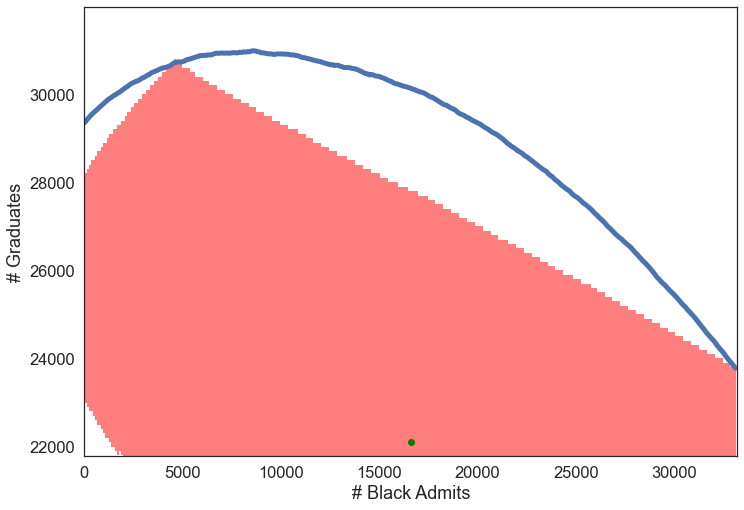

In [10]:
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="white", font_scale=1.5, )
ax = sns.lineplot(data=df_pareto, x='# Black Admits', y='# Graduates',linewidth=5)
errorboxes = []

for outcome_block in outcomes_grid:
    if outcome_block['policy_exists'] == 1:
        errorboxes.append(Rectangle((outcome_block['min_black_admits'] , outcome_block['min_graduates']),GRID_SIZE,GRID_SIZE))

pc = PatchCollection(errorboxes, facecolor='red', alpha=0.5,  edgecolor='none')
                       
ax.add_collection(pc)
plt.scatter(x=(df['R']*0.5).sum(),y=(df['Y']*0.5).sum(),color='green')   
plt.xlim([0, MAX_BLACK_ADMITS])
plt.ylim([df_pareto['# Graduates'].min()-2000, df_pareto['# Graduates'].max()+1000])
plt.show()


    


In [12]:
import pickle
filehandler = open("Fruits.obj","wb")
pickle.dump(outcomes_grid,filehandler)
filehandler.close()
